# CODIGO MODELO TÁCTICO CON METODOLOGIA CHANCE CONSTRAINT

# 1. Simulador de Crecimiento (3munSIM)

In [1]:
#!python3 
"""

@authors: Felipe Ulloa-Fierro
v4.0
fecha: 28/08/2024

"""

'\n\n@authors: Felipe Ulloa-Fierro\nv4.0\nfecha: 28/08/2024\n\n'

In [2]:
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
from typing import List
import random
from pyomo.environ import *
import math
from collections import deque, Counter
import os
import shutil
from pathlib import Path
import csv

## 1.1 FUNCIONES PARA EL SIMULADOR DE CRECIMIENTO (3munSIM)

In [3]:
# Cargar el archivo CSV
df = pd.read_csv("lookup_table.csv", keep_default_na=False)

# Establecer el índice del DataFrame
df.set_index(
    ["Especie", "Zona", "SiteIndex", "Manejo", "Condicion", "DensidadInicial"],
    inplace=True
)

dict_idx = df["id"].to_dict()  # growth_equations_id_dictionary

# Verificar las columnas del DataFrame
#print(df.columns.tolist())  # Esto ayudará a verificar que las columnas existen

# Definir variable para controlar si los datos son proporcionados por el usuario o generados aleatoriamente
usuario_proporciona_datos = False  # Cambia a True si el usuario proporciona datos

# Configuración proporcionada por el usuario
config_usuario = {
    "horizonte": 50,  # Provisto por el usuario
    "rodales": 4,  # Proviene del shapefile
    "edades": [5, 4, 6, 10],  # Proviene del shapefile
    "has": [2, 3, 4, 5],  # Proviene del shapefile
    "especie": ["Pinus", "Pinus", "Pinus", "Eucalyptus"],  # Proviene del shapefile
    "siteIndex": [32, 29, 23, 30],  # Proviene del shapefile
    "zona": [6, 6, 6, 2],  # Proviene del shapefile
    "densidadInicial": [1250, 1250, 1250, 1250],
    "manejo": ["Intensivo", "Intensivo2", "Pulpable", "NA"],  # Proviene del shapefile
    "condición": [
        "PostRaleo1250-700",
        "PostRaleo1250-700",
        "PostRaleo1250-700",
        "SinManejo",
    ],  # Proviene del shapefile
    "id_rodal": ["A11", "D22", "C33", "F34"],  # Proviene del shapefile
    "num_policies_pino": 3,  # Provisto por el usuario
    "policies_pino": [[8, 15], [10, 27], [12, 30]],  # Provisto por el usuario
    "num_policies_eucalyptus": 3,  # Provisto por el usuario
    "policies_eucalyptus": [[8], [10], [17]],  # Provisto por el usuario
}

def generar_combinacion_valida(df, seed=None):
    
    # Fijar la semilla para asegurar reproducibilidad
    if seed is not None:
        np.random.seed(seed)
    
    # Acceder a los valores únicos de las columnas a través del índice
    especies = df.index.get_level_values('Especie').unique().tolist()
    zonas = df.index.get_level_values('Zona').unique().tolist()
    densidades_iniciales = df.index.get_level_values('DensidadInicial').unique().tolist()
    site_indices = df.index.get_level_values('SiteIndex').unique().tolist()
    manejos = df.index.get_level_values('Manejo').unique().tolist()
    condiciones = df.index.get_level_values('Condicion').unique().tolist()

    # Crear un set de todas las combinaciones válidas basadas en el índice del DataFrame
    lookup_set = set(zip(df.index.get_level_values('Especie'),
                         df.index.get_level_values('Zona'),
                         df.index.get_level_values('SiteIndex'),
                         df.index.get_level_values('Manejo'),
                         df.index.get_level_values('Condicion'),
                         df.index.get_level_values('DensidadInicial')))

    while True:
        # Seleccionar aleatoriamente una combinación de valores
        especie = np.random.choice(especies)
        zona = np.random.choice(zonas)
        site_index = np.random.choice(site_indices)
        manejo = np.random.choice(manejos)
        condicion = np.random.choice(condiciones)
        densidad_inicial = np.random.choice(densidades_iniciales)

        # Crear la combinación seleccionada
        combinacion = (especie, zona, site_index, manejo, condicion, densidad_inicial)

        # Verificar si la combinación es válida
        if combinacion in lookup_set:
            return combinacion

def generar_policies_pino(horizonte, edad_min_podaraleo_pino, edad_max_podaraleo_pino, edad_min_cosecha_pino, edad_max_cosecha_pino):
    # Verificar que los rangos de edad sean válidos y estén en orden correcto
    if not (0 < edad_min_podaraleo_pino < edad_max_podaraleo_pino < edad_min_cosecha_pino < edad_max_cosecha_pino < horizonte):
        raise ValueError("Los valores de edad no son válidos o están fuera de rango.")

    policies_pino = []

    # Generar todas las combinaciones posibles de poda/raleo y cosecha
    for poda_raleo in range(edad_min_podaraleo_pino, edad_max_podaraleo_pino + 1):
        for cosecha in range(edad_min_cosecha_pino, edad_max_cosecha_pino + 1):
            policies_pino.append((poda_raleo, cosecha))

    return list(policies_pino)



def generar_policies_eucalyptus(horizonte, edad_min_cosecha_euca, edad_max_cosecha_euca):
    # Verificar que los rangos de edad sean válidos y estén en orden correcto
    if not (0 < edad_min_cosecha_euca < edad_max_cosecha_euca < horizonte):
        raise ValueError("Los valores de edad no son válidos o están fuera de rango.")
    
    policies_eucalyptus = []

    # Generar todas las edades de cosecha dentro del rango
    for cosecha in range(edad_min_cosecha_euca, edad_max_cosecha_euca + 1):
        policies_eucalyptus.append((cosecha,))

    return list(policies_eucalyptus)


# Inicializar listas para almacenar los datos generados
edades_iniciales = []
hectareas = []
ids_rodales = []
especies_aleatorias = []
zonas_aleatorias = []
site_indices_aleatorios = []
densidades_iniciales_aleatorias = []
manejos_aleatorios = []
condiciones_aleatorias = []

if usuario_proporciona_datos:
    # Utilizar los datos proporcionados por el usuario
    config = config_usuario

    # Verificar si los datos proporcionados por el usuario son consistentes
    if len(config["edades"]) != config["rodales"]:
        raise ValueError("El número de edades proporcionadas no coincide con el número de rodales.")
    if len(config["policies_pino"]) != config["num_policies_pino"]:
        raise ValueError("El número de políticas de pino proporcionadas no coincide con el número indicado.")
    if len(config["policies_eucalyptus"]) != config["num_policies_eucalyptus"]:
        raise ValueError("El número de políticas de eucalyptus proporcionadas no coincide con el número indicado.")
else:
    # Generar datos aleatoriamente
    num_rodales = 55
    horizonte = 15
    edad_min_podaraleo_pino=5
    edad_max_podaraleo_pino=8
    edad_min_cosecha_pino=10
    edad_max_cosecha_pino=13
    edad_min_cosecha_euca=5
    edad_max_cosecha_euca=8
    
    for _ in range(num_rodales):  # creo que debo sumarle uno a num_rodales para que haga los 55, ahora esta generando 54.
        # Generar una combinación válida
        combinacion_valida = generar_combinacion_valida(df)

        # Desempaquetar la combinación
        especie, zona, site_index, manejo, condicion, densidad_inicial = combinacion_valida
        
        # Generar edades iniciales y hectáreas aleatoriamente
        edad_inicial = np.random.randint(1, 7)  # Edades iniciales aleatorias entre 1 y 7
        hectarea = round(np.random.uniform(1, 20), 2)  # Hectáreas aleatorias entre 1 y 20

        # Almacenar valores en las listas correspondientes
        edades_iniciales.append(edad_inicial)
        hectareas.append(hectarea)
        especies_aleatorias.append(especie)
        zonas_aleatorias.append(zona)
        site_indices_aleatorios.append(site_index)
        densidades_iniciales_aleatorias.append(densidad_inicial)
        manejos_aleatorios.append(manejo)
        condiciones_aleatorias.append(condicion)

        # Generar ID de rodal aleatorio
        ids_rodales.append(f"{chr(np.random.randint(65, 91))}{np.random.randint(10, 1000)}")

    # Generar políticas aleatorias para Pino y Eucalyptus
#    num_policies_pino = 10
#    num_policies_eucalyptus = 4

    policies_pino = generar_policies_pino(horizonte, edad_min_podaraleo_pino,edad_max_podaraleo_pino,edad_min_cosecha_pino,edad_max_cosecha_pino)
    policies_eucalyptus = generar_policies_eucalyptus(horizonte, edad_min_cosecha_euca,edad_max_cosecha_euca)

    # Crear el diccionario de configuración con datos generados aleatoriamente
    config = {
        "horizonte": horizonte,
        "rodales": num_rodales,
        "edades": edades_iniciales,
        "has": hectareas,
        "especie": especies_aleatorias,
        "siteIndex": site_indices_aleatorios,
        "zona": zonas_aleatorias,
        "densidadInicial": densidades_iniciales_aleatorias,
        "manejo": manejos_aleatorios,
        "condición": condiciones_aleatorias,
        "id_rodal": ids_rodales,
        "num_policies_pino": len(policies_pino),
        "policies_pino": policies_pino,
        "num_policies_eucalyptus": len(policies_eucalyptus),
        "policies_eucalyptus": policies_eucalyptus,
    }


def calc_biomasa(rodal: pd.Series, e: int) -> float:
    return max(rodal["α"] * e ** rodal["β"] + rodal["γ"], 0)

def generar_rodales(
    edades=config["edades"],
    has=config["has"],
    id_rodal=config["id_rodal"],
    tipoespecie=config["especie"],
) -> List[pd.Series]:
    """Generar una lista de rodales usando la configuración dada"""
    rodales = []
    if "id" in df.columns:
        df.set_index("id", inplace=True)  # para asegurarse que 'id' es el índice de df
    for i in range(config["rodales"]):
        key = (
            config["especie"][i],
            config["zona"][i],
            config["siteIndex"][i],
            config["manejo"][i],
            config["condición"][i],
            config["densidadInicial"][i],
        )
        if key not in dict_idx:
            raise KeyError(
                f"No existe un índice para la combinación de claves {key} en la lookup table."
            )
        idx = dict_idx[key]
        if idx not in df.index:  # checkea si idx está en df.index en lugar de df['id'].values
            raise ValueError(f"El índice {idx} no existe en la lookup table.")
        init_ages = edades[i]
        hectareas = has[i]
        rodal_id = id_rodal[i]
        especie = tipoespecie[i]
        rodal = pd.concat(
            (
                df.loc[idx],
                pd.Series(
                    {
                        "eq_id": idx,
                        "edad_in": init_ages,
                        "ha": hectareas,
                        "id_rodal": rodal_id,
                        "TipoEspecie": especie,
                    }
                ),
            )
        )
        rodales.append(rodal)
    return rodales

def generar_rodalesconpolicy(
    rodales=generar_rodales(), horizonte=config["horizonte"]
):
    """Generar una lista de rodales con políticas de manejo aplicadas basadas en la edad del rodal, filtrando solo las políticas factibles."""
    rodales_con_policy = []
    for rodal in rodales:
        if rodal["TipoEspecie"] == "Pinus":
            policies = config["policies_pino"]
        elif rodal["TipoEspecie"] == "Eucapyltus":
            policies = config["policies_eucalyptus"]
        else:
            raise ValueError(
                f"La especie {rodal['TipoEspecie']} no tiene políticas definidas."
            )

        for policy in policies:
            # Filtrar políticas no factibles
            if rodal["TipoEspecie"] == "Pinus":
                if rodal["edad_in"] > policy[0] or rodal["edad_in"] > policy[1]:
                    continue  # Saltar políticas no factibles
            elif rodal["TipoEspecie"] == "Eucapyltus":
                if rodal["edad_in"] > policy[0]:
                    continue  # Saltar políticas no factibles

            rodal_policy = rodal.copy()
            poda_raleo_periodos = []
            cosecha_periodos = []
            edad_rodal = rodal["edad_in"]

            # Simulación del manejo basado en la edad del rodal y sus rotaciones
            for periodo in range(1, horizonte + 1):
                if rodal["TipoEspecie"] == "Pinus":
                    # Verificar si es necesario aplicar poda/raleo o cosecha según la edad
                    if edad_rodal == policy[0]:
                        poda_raleo_periodos.append(periodo)

                    if edad_rodal == policy[1]:
                        cosecha_periodos.append(periodo)
                        edad_rodal = 0  # Reinicia la edad del rodal a 0 después de la cosecha

                elif rodal["TipoEspecie"] == "Eucapyltus":
                    # Solo se aplica la cosecha según la edad
                    if edad_rodal == policy[0]:
                        cosecha_periodos.append(periodo)
                        edad_rodal = 0  # Reinicia la edad del rodal a 0 después de la cosecha

                # Incrementar la edad del rodal para el siguiente periodo
                edad_rodal += 1

            rodal_policy["poda_raleo"] = poda_raleo_periodos
            rodal_policy["cosecha"] = cosecha_periodos
            rodal_policy["horizonte"] = horizonte

            rodales_con_policy.append(rodal_policy)

    return rodales_con_policy


def rotular_condicion(
    edad_poda_raleo: List[int], 
    edad_cosecha: List[int], 
    edades_updated: pd.Series
) -> pd.Series:
    """
    Rotula la condición de manejo del rodal en función de su edad y las edades de poda/raleo y cosecha.
    
    :param edad_poda_raleo: Lista de edades de poda/raleo.
    :param edad_cosecha: Lista de edades de cosecha.
    :param edades_updated: Serie con las edades actualizadas de los rodales.
    :return: Serie con la condición rotulada.
    """
    condiciones = []
    
    # Manejo de listas vacías
    if not edad_poda_raleo:
        edad_poda_raleo = [float('inf')]  # Evita errores en comparación
    if not edad_cosecha:
        edad_cosecha = [float('inf')]  # Evita errores en comparación
    
    for edad in edades_updated:
        # Rotula la condición basado en la edad
        if edad < min(edad_poda_raleo):
            condiciones.append("sin manejo")
        elif edad in edad_poda_raleo:
            condiciones.append("con manejo")
        elif edad >= max(edad_poda_raleo) and edad <= max(edad_cosecha):
            condiciones.append("con manejo")
        else:
            condiciones.append("sin manejo")

    return pd.Series(condiciones)


def generar_codigo_kitral(especie: str, edad: int, condición: str) -> str:
    """Genera un código Kitral basado en la especie, edad y condición."""
    
    key = (especie, edad, condición)
    
    if key[0] == "Pinus":
        if key[1] <= 3:
            value = "PL01" if key[2] == "sin manejo" else "NoCode"
        elif 3 < key[1] <= 11:
            value = "PL02" if key[2] == "sin manejo" else "PL05"
        elif 11 < key[1] <= 17:
            value = "PL03" if key[2] == "sin manejo" else "PL06"
        elif key[1] > 17:
            value = "PL04" if key[2] == "sin manejo" else "PL07"
        else:
            value = "NoCode"
    
    elif key[0] == "Eucapyltus":
        if key[1] <= 3:
            value = "PL08"
        elif 3 < key[1] <= 10:
            value = "PL09"
        else:
            value = "PL10"
    
    else:
        raise ValueError(f"Especie no soportada: {key[0]}")
    
    return value


def simula_bosque(
    rodales_con_policy=generar_rodalesconpolicy(),  # Asegura usar la versión filtrada
    horizonte=config["horizonte"],
    num_policies_pino=config["num_policies_pino"],
    num_policies_eucalyptus=config["num_policies_eucalyptus"],
):
    """Simula el crecimiento del bosque calculando la biomasa para cada rodal con política"""
    bosque = []
    cantidad_raleada_total = []
    cantidad_cosechada_total = []
    resumen = []
    
    biomasa_final_por_rodal = {}

    # Inicializa los contadores de políticas
    policy_counters = {
        "Pinus": 0,
        "Eucapyltus": 0,
    }

    for rodal in rodales_con_policy:  # Usa solo los rodales con políticas factibles
        tabla = pd.DataFrame()
        tabla["periodo"] = range(1, horizonte + 1)
        tabla["edadRodal"] = range(rodal["edad_in"], rodal["edad_in"] + horizonte)

        # Inicializa "edad_updated" con los valores de "edadRodal"
        tabla["edad_updated"] = tabla["edadRodal"]

        # Encuentra los índices donde ocurren las cosechas
        cosecha_indices = [
            tabla[tabla["periodo"] == c].index[0] for c in rodal["cosecha"]
        ]

        # Actualiza los valores de "edad_updated" después de cada cosecha
        for cosecha_index in cosecha_indices:
            # Determina el número de periodos restantes después de la cosecha
            longitud = len(tabla.loc[cosecha_index + 1:, "edad_updated"])

            # Reinicia la edad a 1 después de la cosecha y continúa aumentando en cada periodo
            if longitud > 0:
                valores = range(1, longitud + 1)
                tabla.loc[cosecha_index + 1:, "edad_updated"] = valores

        # Define edad_poda_raleo y edad_cosecha aquí
        edad_poda_raleo = [
            tabla.loc[tabla["periodo"] == pr, "edad_updated"].values[0]
            for pr in rodal["poda_raleo"]
        ] if isinstance(rodal["poda_raleo"], list) else [rodal["poda_raleo"]]
        edad_cosecha = [
            tabla.loc[tabla["periodo"] == pc, "edad_updated"].values[0]
            for pc in rodal["cosecha"]
        ] if isinstance(rodal["cosecha"], list) else [rodal["cosecha"]]

        # Rotular la columna "condición"
        tabla["condición"] = rotular_condicion(
            edad_poda_raleo, edad_cosecha, tabla["edad_updated"]
        )
        
        # Verifica si hay un 'next' rodal
        if pd.isnull(rodal.get("next")) or rodal["next"] == "":
            rodal["poda_raleo"] = -1
            biomasa = []
            for e in tabla["edad_updated"]:
                biomasa.append(calc_biomasa(rodal, e))
        else:
            next_rodal = df.loc[int(rodal["next"])]
            biomasa = []
            poda_raleo_index = 0
            cosecha_index = 0

            for e in tabla["edad_updated"]:
                if (
                    poda_raleo_index < len(edad_poda_raleo)
                    and e == edad_poda_raleo[poda_raleo_index]
                ):
                    biomasa.append(calc_biomasa(rodal, e))
                    poda_raleo_index += 1
                elif (
                    cosecha_index < len(edad_cosecha)
                    and e == edad_cosecha[cosecha_index]
                ):
                    biomasa.append(calc_biomasa(next_rodal, e))
                    cosecha_index += 1
                else:
                    if (
                        poda_raleo_index > 0
                        and e > edad_poda_raleo[poda_raleo_index - 1]
                    ):
                        biomasa.append(calc_biomasa(next_rodal, e))
                    else:
                        biomasa.append(calc_biomasa(rodal, e))

        tabla["biomasa"] = (pd.Series(biomasa) * rodal["ha"]).round(3)
        tabla["id_rodal"] = rodal["id_rodal"]
        tabla["Especie"] = rodal["TipoEspecie"]

        # Crea la columna "kitral_class" utilizando la función generar_codigo_kitral
        tabla["kitral_class"] = tabla.apply(
            lambda row: generar_codigo_kitral(
                row["Especie"], row["edad_updated"], row["condición"]
            ),
            axis=1,
        )

        edad_initial = tabla.loc[
            tabla["edadRodal"] == rodal["edad_in"], "edad_updated"
        ].values[0]
        edad_final = tabla.loc[
            tabla["periodo"] == rodal["horizonte"], "edad_updated"
        ].values[0]

        # Agrega los valores a la tabla de resumen
        if rodal["TipoEspecie"] == "Pinus":
            politica = f"policy_pino {policy_counters['Pinus'] % num_policies_pino + 1}"
            policy_counters["Pinus"] += 1
        elif rodal["TipoEspecie"] == "Eucapyltus":
            politica = f"policy_eucalyptus {policy_counters['Eucapyltus'] % num_policies_eucalyptus + 1}"
            policy_counters["Eucapyltus"] += 1
        else:
            raise ValueError(
                f"La especie {rodal['TipoEspecie']} no tiene políticas definidas."
            )

        tabla["politica"] = politica

        # Calcula la cantidad cosechada por cada tiempo de cosecha por rodal y policy
        cantidad_cosechada = []
        for pc in rodal["cosecha"]:
            if len(tabla.loc[tabla["periodo"] == pc, "biomasa"].values) > 0:
                cantidad_cosechada.append(
                    tabla.loc[tabla["periodo"] == pc, "biomasa"].values[0]
                )
            else:
                cantidad_cosechada.append(0)

        cantidad_cosechada_total.append(cantidad_cosechada)

        # Calcula cantidad_raleada usando el método proporcionado
        cantidad_raleada = []
        if isinstance(rodal["poda_raleo"], list):
            for pr in rodal["poda_raleo"]:
                if pr != -1:
                    # Aquí añadimos la verificación de tamaño para evitar el IndexError
                    if (
                        len(tabla.loc[tabla["periodo"] == pr, "biomasa"].values) > 0
                        and len(tabla.loc[tabla["periodo"] == pr + 1, "biomasa"].values) > 0
                    ):
                        cantidad_raleada.append(
                            (
                                tabla.loc[tabla["periodo"] == pr, "biomasa"].values[0]
                                - tabla.loc[tabla["periodo"] == pr + 1, "biomasa"].values[0]
                            )
                        )
                    else:
                        cantidad_raleada.append(0)
                else:
                    cantidad_raleada.append(0)
        else:
            pr = rodal["poda_raleo"]
            if pr != -1:
                if (
                    len(tabla.loc[tabla["periodo"] == pr, "biomasa"].values) > 0
                    and len(tabla.loc[tabla["periodo"] == pr + 1, "biomasa"].values) > 0
                ):
                    cantidad_raleada.append(
                        (
                            tabla.loc[tabla["periodo"] == pr, "biomasa"].values[0]
                            - tabla.loc[tabla["periodo"] == pr + 1, "biomasa"].values[0]
                        )
                    )
                else:
                    cantidad_raleada.append(0)
            else:
                cantidad_raleada.append(0)
        
        
        # Crear la columna "bioOPT" con ceros
        tabla["bioOPT"] = 0

        for pr in rodal["poda_raleo"] if isinstance(rodal["poda_raleo"], list) else [rodal["poda_raleo"]]:
            if pr in tabla["periodo"].values:
                if pr != -1:
                   # Aquí añadimos la verificación de tamaño para evitar el IndexError
                    if (
                        len(tabla.loc[tabla["periodo"] == pr, "biomasa"].values) > 0
                        and len(tabla.loc[tabla["periodo"] == pr + 1, "biomasa"].values) > 0
                    ): 
                    
                        tabla.loc[tabla["periodo"] == pr, "bioOPT"] = tabla.loc[tabla["periodo"] == pr, "biomasa"].values[0] - tabla.loc[tabla["periodo"] == pr + 1, "biomasa"].values[0]
                    else:
                        tabla.loc[tabla["periodo"] == pr, "bioOPT"] = 0
                        
        # Continua con el cálculo de "bioOPT" para los periodos de cosecha
        for pc in rodal["cosecha"] if isinstance(rodal["cosecha"], list) else [rodal["cosecha"]]:
            if pc in tabla["periodo"].values:
                tabla.loc[tabla["periodo"] == pc, "bioOPT"] = tabla.loc[tabla["periodo"] == pc, "biomasa"].values[0]


        cantidad_cosechada_total = [
            [round(x, 3) for x in sublist] for sublist in cantidad_cosechada_total
        ]
        cantidad_raleada_total = [
            [round(x, 3) for x in sublist] for sublist in cantidad_raleada_total
        ]

         # **Elimina la columna "edadRodal" antes de agregar la tabla al bosque**
        tabla = tabla.drop(columns=["edadRodal"])
        # **Renombra la columna "edad_updated" a "edad_rodal" antes de agregar la tabla al bosque**
        tabla = tabla.rename(columns={"edad_updated": "edad_rodal"})
        
        # Guardar la biomasa cuando el horizonte coincida con el periodo
        if horizonte in tabla["periodo"].values:
            biomasa_final_por_rodal[rodal["id_rodal"]] = tabla.loc[tabla["periodo"] == horizonte, "biomasa"].values[0]

        bosque.append(tabla)

        resumen.append(
            {
                "id_rodal": rodal["id_rodal"],
                "especie": rodal["TipoEspecie"],
                "has": rodal["ha"],
                "edad_inicial": edad_initial,
                "edad_final": edad_final,
                "policy": politica,
            }
        )

    return bosque, cantidad_raleada_total, cantidad_cosechada_total, resumen, biomasa_final_por_rodal, horizonte

In [4]:
def getBiomasa4Opti(bosque,resumen):
    
    # asumiendo que `bosque` es una lista de DataFrames
    # Primero, extraemos la columna "biomasa" de cada DataFrame y la convertimos en una lista de listas
    biomasa_list = [df["bioOPT"].values for df in bosque]

    # Convertimos esta lista de listas en un DataFrame
    biomasa_df = pd.DataFrame(biomasa_list).T  # Transponemos para obtener las 30 filas y 136 columnas

    # Asignar nombres a las columnas si lo deseas
    biomasa_df.columns = [f"Rodales_{i+1}" for i in range(len(bosque))]
    
    # Crear el DataFrame df_test con id_rodal y policy
    id_rodales = [item['id_rodal'] for item in resumen]
    policies = [item['policy'] for item in resumen]
    especies = [item["especie"] for item in resumen]

    # Crear el DataFrame df_test con tres filas y 136 columnas
    df_test = pd.DataFrame([id_rodales, policies, especies])

    # Asegúrate de que df_test tenga 136 columnas
    assert df_test.shape[1] == biomasa_df.shape[1]

    # Crear un DataFrame vacío con las mismas columnas que df_test
    # para asegurarnos de que biomasa_df tenga las mismas columnas
    # Es importante tener el mismo número de columnas
      # Asegúrate de que biomasa_data tenga 30 filas y 136 columnas
    biomasa_df.columns = df_test.columns

    # Concatenar df_test y biomasa_df verticalmente
    combined_df = pd.concat([df_test, biomasa_df], axis=0)

    # Renombrar las filas para mayor claridad
    combined_df.index = ['id_rodal', 'policy', "especie"] + [i+1 for i in range(len(biomasa_df))]
    
    # Crear un MultiIndex a partir de las dos primeras filas
    combined_df.columns = pd.MultiIndex.from_arrays([combined_df.iloc[0], combined_df.iloc[1], combined_df.iloc[2]])

    # 2. Eliminar las filas originales que se convirtieron en MultiIndex
    combined_df = combined_df.drop(combined_df.index[[0, 1, 2]])

    # Convertir los datos a un diccionario
    a_I_J_dict = combined_df.stack().stack().stack().to_dict()
    
    
    return a_I_J_dict

### 1.1.1 Generamos el bosque (sin espacialidad) y la biomasa que se obtendria con diferentes politicas de manejo

    #### obtenemos el main input para la optimización sin incertidumbre a_ijt -> a_I_J_dict.
    #### generamos los conjuntos para el modelo.

In [5]:
bosque, cantidad_raleada_total, cantidad_cosechada_total, resumen, biomasa_final_por_rodal, horizonte=simula_bosque(
    rodales_con_policy=generar_rodalesconpolicy(),  # Asegura usar la versión filtrada
    horizonte=config["horizonte"],
    num_policies_pino=config["num_policies_pino"],
    num_policies_eucalyptus=config["num_policies_eucalyptus"],
)

a_I_J_dict=getBiomasa4Opti(bosque,resumen)

I_pino = set()

for df in bosque:
    # Filtrar el DataFrame para solo incluir filas donde la especie sea "Pinus"
    pinus_df = df[df["Especie"] == "Pinus"]
    # Actualizar el conjunto I con los valores únicos de 'id_rodal' del DataFrame filtrado
    I_pino.update(pinus_df['id_rodal'].unique())
    
I_euca = set()

for df in bosque:
    # Filtrar el DataFrame para solo incluir filas donde la especie sea "Pinus"
    euca_df = df[df["Especie"] == "Eucapyltus"]
    # Actualizar el conjunto I con los valores únicos de 'id_rodal' del DataFrame filtrado
    I_euca.update(euca_df['id_rodal'].unique())
    
I = I_pino | I_euca
    
J_pino = set()
J_euca = set()

# Suponiendo que 'bosque' es una lista de DataFrames
for df in bosque:
    # Itera sobre las políticas únicas en cada DataFrame
    for policy in df['politica'].unique():
        if 'pino' in policy:
            J_pino.add(policy)
        elif 'eucalyptus' in policy:
            J_euca.add(policy)

# Crea el conjunto total J como la unión de J_pino y J_eucalyptus
J = J_pino | J_euca  # También puedes usar J_pino.union(J_eucalyptus)

T=set()

for df in bosque:
    T.update(df['politica'].unique())
    
E_1={"Pinus"}
E_2={"Eucapyltus"}

T=RangeSet(1,horizonte)



## 1.2 Creamos el modelo de optimización "P0" usando Pyomo

In [6]:
# Crear un modelo de Pyomo
model = ConcreteModel()

# Crear listas ordenadas a partir de los sets
I_pino_list = sorted(I_pino)
I_euca_list = sorted(I_euca)
I_list = sorted(I)
J_pino_list = sorted(J_pino)
J_euca_list = sorted(J_euca)
J_list = sorted(J)
E_1_list = sorted(E_1)
E_2_list = sorted(E_2)

# Inicializar conjuntos en Pyomo con listas ordenadas
model.I_pino = Set(initialize=I_pino_list)
model.I_euca = Set(initialize=I_euca_list)
model.I = Set(initialize=I_list)
model.J_pino = Set(initialize=J_pino_list)
model.J_euca = Set(initialize=J_euca_list)
model.J = Set(initialize=J_list)
model.T = RangeSet(1, horizonte)  # No necesita cambio porque ya es un RangeSet
model.Epino = Set(initialize=E_1_list)
model.Eeuca = Set(initialize=E_2_list)

# Parámetros
model.precio_pino = Param(initialize=1100)
model.precio_euca = Param(initialize=1200)
model.B_p = Param(initialize=12000)
model.tasa = Param(initialize=0.05)

# 1. Definir los índices válidos para xpino y xeuca basados en a_I_J_dict

valid_pino_indices = [(i, j) for i in model.I_pino for j in model.J_pino 
                      if any((t, e, j, i) in a_I_J_dict for t in model.T for e in model.Epino)]

valid_euca_indices = [(i, j) for i in model.I_euca for j in model.J_euca
                      if any((t, e, j, i) in a_I_J_dict for t in model.T for e in model.Eeuca)]

# 2. Definir las variables binarias para las combinaciones válidas

model.xpino = Var(valid_pino_indices, within=Binary)
model.xeuca = Var(valid_euca_indices, within=Binary)

model.v_t=Var(model.T, within=NonNegativeReals)

# 3. Definir la función objetivo usando las combinaciones válidas

def objetivo_rule(model):
    # Suma para pino
    objetivo_pino = sum(
        a_I_J_dict[(t, e, j, i)] * model.xpino[i, j] * model.precio_pino * 1 / (1 + model.tasa)**t
        for t in model.T for e in model.Epino for j in model.J_pino for i in model.I_pino
        if (i, j) in valid_pino_indices and (t, e, j, i) in a_I_J_dict
    )
    
    # Suma para eucalipto
    objetivo_euca = sum(
        a_I_J_dict[(t, e, j, i)] * model.xeuca[i, j] * model.precio_euca * 1 / (1 + model.tasa)**t
        for t in model.T for e in model.Eeuca for j in model.J_euca for i in model.I_euca
        if (i, j) in valid_euca_indices and (t, e, j, i) in a_I_J_dict
    )
    
    return objetivo_pino + objetivo_euca

model.objetivo = Objective(rule=objetivo_rule, sense=maximize)

# 4. Restricciones 

# Restricción de asignación única por unidad de manejo pino
def single_assignment_rule_pino(model, i):
    return sum(model.xpino[i, j] for j in model.J_pino if (i, j) in valid_pino_indices) == 1

model.single_assignment_pino = Constraint(model.I_pino, rule=single_assignment_rule_pino)

# Restricción de asignación única por unidad de manejo eucalipto
def single_assignment_rule_euca(model, i):
    return sum(model.xeuca[i, j] for j in model.J_euca if (i, j) in valid_euca_indices) == 1

model.single_assignment_euca = Constraint(model.I_euca, rule=single_assignment_rule_euca)

# Restricción para guardar cantidades marginales por periodo de biomasa cosechada
def contribucion_marginal_biomasa(model, t):
    return sum(
        a_I_J_dict[(t, e, j, i)] * model.xpino[i, j]
        for e in model.Epino for j in model.J_pino for i in model.I_pino
        if (t, e, j, i) in a_I_J_dict
    ) + sum(
        a_I_J_dict[(t, e, j, i)] * model.xeuca[i, j]
        for e in model.Eeuca for j in model.J_euca for i in model.I_euca
        if (t, e, j, i) in a_I_J_dict
    ) == model.v_t[t]

model.r2 = Constraint(model.T, rule=contribucion_marginal_biomasa)

# Restricción para que la biomasa en el periodo t+1 sea mayor o igual que en el periodo t
def rendimiento_no_decreciente(model, t):
    if t < model.T.last():
        return model.v_t[t + 1] >= model.v_t[t]
    else:
        return Constraint.Skip

model.r3 = Constraint(model.T, rule=rendimiento_no_decreciente)

# Restricción de sostenibilidad del bosque
def cantidad_minima_bosque_en_pie_al_final_del_horizonte(model):
    return sum(
        biomasa_final_por_rodal[i] * model.xpino[i, j]
        for i, j in valid_pino_indices
        if i in biomasa_final_por_rodal
    ) + sum(
        biomasa_final_por_rodal[i] * model.xeuca[i, j]
        for i, j in valid_euca_indices
        if i in biomasa_final_por_rodal
    ) >= model.B_p

model.r4 = Constraint(rule=cantidad_minima_bosque_en_pie_al_final_del_horizonte)

### 1.2.1 LLamamos al solver (Gurobi) para resolver el modelo de optimización "P0"

In [7]:
solver = SolverFactory('gurobi')
solver.options['MIPGap'] = 0.05  # Establece el MIPGap a 5%
#    solver.options['TimeLimit'] = 600  # Establece un límite de tiempo de 600 segundos
solver.solve(model, tee=True)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-26
Read LP format model from file C:\Users\fullo\AppData\Local\Temp\tmp426gbth2.pyomo.lp
Reading time = 0.02 seconds
x552: 86 rows, 552 columns, 1674 nonzeros
Set parameter MIPGap to value 0.05
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11+.0 (26120.2))

CPU model: Intel(R) Core(TM) i3-8145U CPU @ 2.10GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 86 rows, 552 columns and 1674 nonzeros
Model fingerprint: 0x69ec2c09
Variable types: 16 continuous, 536 integer (536 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+03]
  Objective range  [3e+04, 5e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Presolve removed 3 rows and 216 columns
Presolve time: 0.02s
Presolved: 83 rows, 336 columns, 1021 nonzeros
Variable types: 13 continuous, 323 integer (323 binary)



{'Problem': [{'Name': 'x552', 'Lower bound': 58868805.359868705, 'Upper bound': 61233946.66233525, 'Number of objectives': 1, 'Number of constraints': 86, 'Number of variables': 552, 'Number of binary variables': 536, 'Number of integer variables': 536, 'Number of continuous variables': 16, 'Number of nonzeros': 1674, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'Return code': '0', 'Message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Wall time': '0.746999979019165', 'Error rc': 0, 'Time': 1.5580847263336182}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

### 1.2.2 Obtengo el valor de las variables de decisión

In [8]:
vt_vector=[model.v_t[t].value for t in model.T] 

In [9]:
# Inicializar listas para almacenar los resultados
xpino_values = []
xeuca_values = []

# Obtener valores de xpino mayores que cero
for i, j in model.xpino:
    if model.xpino[i, j].value > 0:
        xpino_values.append((i, j))

# Obtener valores de xeuca mayores que cero
for i, j in model.xeuca:
    if model.xeuca[i, j].value > 0:
        xeuca_values.append((i, j))

In [10]:
vt_vector

[1831.1509999999998,
 3478.5969999999998,
 3502.8209999999995,
 3527.3100000000004,
 4749.885,
 5061.266,
 5235.561000000001,
 5474.035,
 5474.4,
 5519.218,
 6224.6630000000005,
 6243.687,
 6375.34,
 6899.554999999999,
 7045.053000000001]

# 2. A partir de la solución optima de P0 obtenemos la data para crear los rasters por periodo.

In [11]:
def getData4raster(xpino_values, xeuca_values, bosque, resumen):

    # Une ambas listas para facilitar la búsqueda
    indexes_combined = xpino_values + xeuca_values

    # Lista donde almacenaremos los DataFrames filtrados
    filas_filtradas = []

    # Itera sobre cada DataFrame en la lista 'bosque'
    for df in bosque:
        # Filtra las filas cuyo (id_rodal, politica) esté en indexes_combined
        df_filtrado = df[df[['id_rodal', 'politica']].apply(tuple, axis=1).isin(indexes_combined)]

        # Agrega el DataFrame filtrado a la lista
        filas_filtradas.append(df_filtrado)

    # Concatena todas las filas filtradas en un solo DataFrame
    df4raster = pd.concat(filas_filtradas, ignore_index=True)

    # Convertir la lista resumen en un DataFrame
    resumen_df = pd.DataFrame(resumen)

    resumen_df = resumen_df.drop_duplicates(subset='id_rodal')

    # Realiza la unión basándote solo en 'id_rodal' y agrega la columna 'has'
    df4raster = pd.merge(df4raster, resumen_df[['id_rodal', 'has']], 
                            on='id_rodal', how='left')
    
    return df4raster

## Funciones para crear un paisaje aleatorio el cual evolucionará periodo a periodo basado en la politica óptima.

### Tambien se crean funciones para visualizar el paisaje y además crear de manera ordenada tantos rasters como periodos sean condiserados.

In [12]:
def get_landscape(df4raster, kitralCodes_RASTER_dict, cell_size=100):

    rodales=(df4raster["id_rodal"].unique()).tolist()
    periodoss=(df4raster["periodo"].unique()).tolist()
    especiess=(df4raster["Especie"].unique()).tolist()
    
    # Si solo te interesa el primer valor (por si hay varias filas con "Z26")
    has_dict={}
    for i in rodales:
        aux_has = df4raster.loc[df4raster["id_rodal"] == i, "has"].values[0]
        has_dict[i]=aux_has


    especie_dict={}    
    for i in rodales:
        aux_especie=df4raster.loc[df4raster["id_rodal"] == i, "Especie"].values[0]
        especie_dict[i]=aux_especie
        
    kitralcode_dict={}
    for i in rodales:
        for j in periodoss:
            aux_kitralcode = df4raster.loc[(df4raster["id_rodal"] == i) & (df4raster["periodo"] == j), "kitral_class"].values
            kitralcode_dict[(i,j)]=aux_kitralcode

            # para asegurarse de que el valor no esté vacío antes de asignarlo
            if len(aux_kitralcode) > 0:
                kitralcode_dict[(i, j)] = aux_kitralcode[0]  

    kitralCodes4raster_dict={}
    for i,j in kitralcode_dict.keys():
        kitralCodes4raster_dict[(i,j)]=kitralCodes_RASTER_dict[kitralcode_dict[(i,j)]]
        
    
    total_surface=sum(has_dict.values())
    
    area_total_m2 = total_surface * 10_000  # Convertir a metros cuadrados

    # para definir la resolución espacial y calcular píxeles totales
    # cell_size = 100 Tamaño de celda en metros (10x10 metros -> 100 m² por píxel)
    num_pixels_total = area_total_m2 / (cell_size ** 2)  # Número total de píxeles

    pixels_dict={}

    for i in has_dict.keys():       # aqui calculamos cuantos pixeles se deberian asociar a cada rodal
        key=i
        values=(has_dict[i]*10_000) / (cell_size ** 2) 
        values=values.round().astype(int)
        pixels_dict[key]=values

    total_pixels_obtained=sum(pixels_dict.values())
    
        # Calcular el tamaño aproximado de una grilla cuadrada
    lado_grilla = math.sqrt(total_pixels_obtained)

    # Redondear hacia arriba para obtener un número entero
    rows = math.ceil(lado_grilla)
    cols = math.ceil(lado_grilla)

    #print(f"Dimensiones de la grilla cuadrada: {rows} filas x {cols} columnas")
    
    # Crear un diccionario de mapeo de rodal_id a números enteros
    rodal_mapping = {rodal_id: idx for idx, rodal_id in enumerate(pixels_dict.keys(), 1)}

    # Función para asignar píxeles conexos a cada rodal
    def asignar_pixels_conexos(rodal_id, num_pixels, grid):
        # Encontrar una posición inicial disponible
        start_pos = np.argwhere(grid == -1)

        # Validar si hay píxeles disponibles
        if len(start_pos) == 0:
            print(f"No hay píxeles disponibles para iniciar el rodal {rodal_id}")
            return

        # Tomar la primera posición disponible
        start_x, start_y = start_pos[0]

        # Obtener el número mapeado del rodal
        rodal_num = rodal_mapping[rodal_id]

        # Asignar píxeles de manera conexa usando BFS
        grid[start_x, start_y] = rodal_num
        cola = deque([(start_x, start_y)])
        count = 1

        while cola and count < num_pixels:
            x, y = cola.popleft()

            # Vecinos posibles (8 conectados)
            vecinos = [(x-1, y), (x+1, y), (x, y-1), (x, y+1), (x-1, y-1), (x+1, y+1), (x-1, y+1), (x+1, y-1)]
            for nx, ny in vecinos:
                if 0 <= nx < grid.shape[0] and 0 <= ny < grid.shape[1] and grid[nx, ny] == -1:
                    grid[nx, ny] = rodal_num
                    cola.append((nx, ny))
                    count += 1
                    if count == num_pixels:
                        break

        if count < num_pixels:
            print(f"Advertencia: Solo se asignaron {count} de los {num_pixels} píxeles requeridos para el rodal {rodal_id}")

    # Función para reasignar píxeles cuando un rodal tiene un número incorrecto de píxeles asignados
    def reasignar_rodal(rodal_id, num_pixels, grid):
        rodal_num = rodal_mapping[rodal_id]
        # Liberar los píxeles actuales del rodal
        grid[grid == rodal_num] = -1

        # Llamar nuevamente a la función de asignar píxeles
        asignar_pixels_conexos(rodal_id, num_pixels, grid)

    # Función para verificar y corregir las asignaciones de píxeles
    def verificar_y_corregir(grid, pixels_dict):
        rodal_count = Counter(grid.flatten())

        for rodal_id, expected_count in pixels_dict.items():
            rodal_num = rodal_mapping[rodal_id]
            actual_count = rodal_count.get(rodal_num, 0)
            if actual_count != expected_count:
                print(f"Rodal {rodal_id}: Incorrecto (esperado {expected_count}, asignado {actual_count}). Reasignando...")
                reasignar_rodal(rodal_id, expected_count, grid)
            else:
                print(f"Rodal {rodal_id}: Correcto ({actual_count} píxeles asignados).")

        return grid

    # Verificar si los píxeles están bien asignados
    def verificar_asignacion(grid, pixels_dict):
        rodal_count = Counter(grid.flatten())

        for rodal_id, expected_count in pixels_dict.items():
            rodal_num = rodal_mapping[rodal_id]
            actual_count = rodal_count.get(rodal_num, 0)
            if actual_count == expected_count:
                print(f"Rodal {rodal_id}: Correcto ({actual_count} píxeles asignados).")
            else:
                print(f"Rodal {rodal_id}: Incorrecto (esperado {expected_count}, asignado {actual_count}).")

        # Verificar si hay rodales no esperados
        rodales_no_esperados = [rodal_num for rodal_num in rodal_count if rodal_num != 0 and rodal_num not in rodal_mapping.values()]
        if rodales_no_esperados:
            print(f"Advertencia: Hay rodales no esperados en la grilla: {rodales_no_esperados}")
        else:
            print("No hay rodales no esperados en la grilla.")

    # Definir la grilla y los rodales
    grid_size = (rows, cols)
    grid = np.full(grid_size, -1)  # Inicialmente todos los píxeles están sin asignar (-1)


    # Asignar píxeles a cada rodal
    for rodal_id, num_pixels in pixels_dict.items():
        asignar_pixels_conexos(rodal_id, num_pixels, grid)

    # Verificar y corregir las asignaciones hasta que todo esté correcto
    correcto = False
    while not correcto:
        grid = verificar_y_corregir(grid, pixels_dict)
        rodal_count = Counter(grid.flatten())
        incorrectos = [rodal_id for rodal_id, expected_count in pixels_dict.items() if rodal_count.get(rodal_mapping[rodal_id], 0) != expected_count]

        if not incorrectos:
            correcto = True
            print("Todas las asignaciones son correctas.")
            
        
    return grid, rodal_mapping, kitralCodes4raster_dict, cell_size


# Función para visualizar la grilla con etiquetas
def visualizar_grilla_con_etiquetas(grid, rodal_mapping):
    
    # Crear una paleta de colores para los rodales
    num_rodales = len(rodal_mapping)
    cmap = plt.get_cmap('Spectral', num_rodales)  # 'tab20' es una paleta con hasta 20 colores distintos, Spectral tiene mas weas 
    norm = mcolors.BoundaryNorm(boundaries=np.arange(num_rodales+1)-0.5, ncolors=num_rodales)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(grid, cmap=cmap, norm=norm, interpolation='none')
    
    # Crear una barra de colores para entender qué número de rodal corresponde a qué color
    cbar = plt.colorbar(ticks=np.arange(num_rodales))
    cbar.set_label('stand ID')
    cbar.set_ticks(np.arange(num_rodales))
    cbar.set_ticklabels([key for key in rodal_mapping.keys()], fontsize=8)
    
    # Añadir etiquetas a cada celda
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            rodal_id = grid[i, j]
            if rodal_id != -1:  # Considerar solo celdas asignadas
                plt.text(j, i, f'{rodal_id}', ha='center', va='center', color='black', fontsize=8)

#    plt.title('Visualización de la Grilla por Rodales')
    plt.gca().invert_yaxis()  # Invertir el eje Y para que (0,0) esté en la esquina superior izquierda
    plt.show()

# FUnción para conocer la coordenada de las celdas que componen un rodal.
def generar_coord_dict(grid):
    # Inicializar un diccionario vacío
    coord_dict = {}

    # Obtener el tamaño de la grilla
    rows, cols = grid.shape

    # Recorrer cada celda de la grilla
    for x in range(rows):
        for y in range(cols):
            rodal_id = grid[x, y]
            
            # Si el rodal no es 0 (no asignado), agregar la coordenada al diccionario
            if rodal_id != 0:
                if rodal_id not in coord_dict:
                    coord_dict[rodal_id] = []  # Inicializar lista si no existe
                coord_dict[rodal_id].append((x, y))  # Agregar coordenada (x, y)

    return coord_dict    

def generar_code_grid(grid, coord_dict, kitralCodes4raster_dict, inverse_rodal_mapping):
    # Crear una grilla vacía con el mismo tamaño que la grilla original
    code_grid = np.zeros_like(grid)

    # Recorrer el diccionario de coordenadas
    for numeric_rodal_id, coords in coord_dict.items():
        # Verificar si el id numérico tiene un rodal_id original asociado
        if numeric_rodal_id in inverse_rodal_mapping:
            original_rodal_id = inverse_rodal_mapping[numeric_rodal_id]
        else:
            # Si no tiene mapeo, asignar valor 101
            original_rodal_id = None
        
        # Verificar si el rodal_id original existe en kitralCodes4raster_dict para el periodo 1
        if original_rodal_id and (original_rodal_id, 1) in kitralCodes4raster_dict:
            # Obtener el código de combustible del rodal para el periodo 1
            fuel_code = kitralCodes4raster_dict[(original_rodal_id, 1)]
        else:
            # Si no existe, asignar el valor 101
            fuel_code = 101
        
        # Asignar el código de combustible a todas las coordenadas del rodal
        for (x, y) in coords:
            code_grid[x, y] = fuel_code
    
    return code_grid


def crear_raster_file(file_name, grid, rows, cols, cell_size, xllcorner=0, yllcorner=0, nodata_value=-9999):
    """
    Función para crear un archivo raster en formato .asc a partir de la grilla dada con formato UNIX.
    """
    with open(file_name, 'w', newline='\n') as f:  # Asegurar el formato UNIX (LF)
        # Escribir encabezado
        f.write(f"ncols         {cols}\n")
        f.write(f"nrows         {rows}\n")
        f.write(f"xllcorner     {xllcorner}\n")
        f.write(f"yllcorner     {yllcorner}\n")
        f.write(f"cellsize      {cell_size}\n")
        f.write(f"NODATA_value  {nodata_value}\n")
        
        # Escribir datos de la grilla
        for row in grid:
            f.write(' '.join(map(str, row)) + '\n')
            
            
def generar_code_grid_period(grid, coord_dict, kitralCodes4raster_dict, inverse_rodal_mapping, periodo):
    """
    Genera una grilla (code_grid) para un periodo específico asignando los códigos de combustible.
    
    Args:
    - grid: Grilla base.
    - coord_dict: Diccionario con coordenadas de los píxeles por rodal.
    - kitralCodes4raster_dict: Diccionario con los códigos de combustible por rodal y periodo.
    - inverse_rodal_mapping: Mapeo inverso de id numéricos a rodal_id originales.
    - periodo: Periodo para el cual se genera la code_grid.
    
    Returns:
    - code_grid: Grilla con los códigos de combustible asignados.
    """
    code_grid = np.zeros_like(grid)
    
    for numeric_rodal_id, coords in coord_dict.items():
        original_rodal_id = inverse_rodal_mapping.get(numeric_rodal_id, None)
        
        if original_rodal_id is not None:
            if (original_rodal_id, periodo) in kitralCodes4raster_dict:
                code = kitralCodes4raster_dict[(original_rodal_id, periodo)]
            else:
                code = 101  # Si no se encuentra en kitralCodes4raster_dict, asignar 101
            
            for (x, y) in coords:
                code_grid[x, y] = code
        else:
            # Si el rodal no se encuentra en inverse_rodal_mapping, asignar 101
            for (x, y) in coords:
                code_grid[x, y] = 101
                
    return code_grid


def crear_rasters_para_periodos(grid, coord_dict, kitralCodes4raster_dict, inverse_rodal_mapping, rows, cols, cell_size, num_periodos, lookup_tablecsv_path=None, Weathercsv_path=None):
    """
    Genera múltiples archivos .asc, uno para cada periodo de tiempo, y copia dos archivos .csv 
    en la carpeta raíz de cada directorio `raster_period<i>`.

    Args:
    - grid: Grilla base.
    - coord_dict: Diccionario con coordenadas de los píxeles por rodal.
    - kitralCodes4raster_dict: Diccionario con los códigos de combustible por rodal y periodo.
    - inverse_rodal_mapping: Mapeo inverso de id numéricos a rodal_id originales.
    - rows: Número de filas en la grilla.
    - cols: Número de columnas en la grilla.
    - cell_size: Tamaño de cada celda en la grilla.
    - num_periodos: Número total de periodos.
    - lookup_tablecsv_path: Ruta al archivo kitral_lookup_table.csv
    - Weathercsv_path: Ruta al archivo Weather.csv
    """
    base_dir = Path('3mun_rasters')

    # Crear el directorio base si no existe
    if not base_dir.exists():
        base_dir.mkdir()

    for periodo in range(1, num_periodos + 1):
        # Crear la carpeta raster_period<i>
        periodo_folder = base_dir / f'raster_period{periodo}'
        periodo_folder.mkdir(exist_ok=True)
        
        # Generar la code_grid para el periodo actual
        code_grid = generar_code_grid_period(grid, coord_dict, kitralCodes4raster_dict, inverse_rodal_mapping, periodo)
        
        # Definir el nombre del archivo .asc para el periodo actual
        filename = periodo_folder / 'fuels.asc'
        
        # Crear el archivo .asc
        crear_raster_file(filename, code_grid, rows, cols, cell_size)
        
        # Crear la carpeta 'fires_result' dentro de cada 'raster_period<i>'
        fires_result_folder = periodo_folder / 'fires_result'
        fires_result_folder.mkdir(exist_ok=True)
        
        # Copiar los archivos .csv dentro de la carpeta raíz raster_period<i>
        if lookup_tablecsv_path and Path(lookup_tablecsv_path).exists():
            shutil.copy(lookup_tablecsv_path, periodo_folder)
        else:
            print(f"Archivo {lookup_tablecsv_path} no encontrado.")

        if Weathercsv_path and Path(Weathercsv_path).exists():
            shutil.copy(Weathercsv_path, periodo_folder)
        else:
            print(f"Archivo {Weathercsv_path} no encontrado.")
        
        print(f"Carpeta y archivo raster para el periodo {periodo} generados correctamente.")


### llamámos a las mismas aqui

Rodal R417: Correcto (17 píxeles asignados).
Rodal K670: Correcto (8 píxeles asignados).
Rodal J320: Correcto (2 píxeles asignados).
Rodal E107: Correcto (18 píxeles asignados).
Rodal C413: Correcto (6 píxeles asignados).
Rodal F887: Correcto (5 píxeles asignados).
Rodal K156: Correcto (1 píxeles asignados).
Rodal Y775: Correcto (11 píxeles asignados).
Rodal Q15: Correcto (5 píxeles asignados).
Rodal A503: Correcto (3 píxeles asignados).
Rodal V75: Correcto (2 píxeles asignados).
Rodal L628: Correcto (4 píxeles asignados).
Rodal M54: Correcto (16 píxeles asignados).
Rodal Z24: Correcto (11 píxeles asignados).
Rodal G313: Correcto (9 píxeles asignados).
Rodal A332: Correcto (3 píxeles asignados).
Rodal B471: Correcto (7 píxeles asignados).
Rodal Q725: Correcto (12 píxeles asignados).
Rodal A959: Correcto (12 píxeles asignados).
Rodal Y421: Correcto (1 píxeles asignados).
Rodal H634: Correcto (19 píxeles asignados).
Rodal S519: Correcto (5 píxeles asignados).
Rodal J751: Correcto (4 píxe

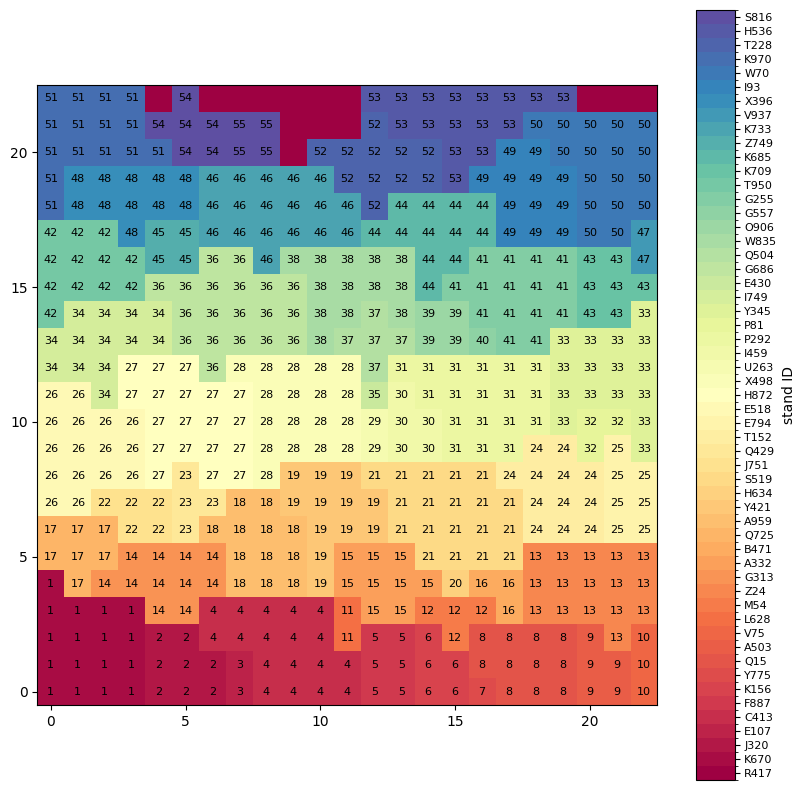

Carpeta y archivo raster para el periodo 1 generados correctamente.
Carpeta y archivo raster para el periodo 2 generados correctamente.
Carpeta y archivo raster para el periodo 3 generados correctamente.
Carpeta y archivo raster para el periodo 4 generados correctamente.
Carpeta y archivo raster para el periodo 5 generados correctamente.
Carpeta y archivo raster para el periodo 6 generados correctamente.
Carpeta y archivo raster para el periodo 7 generados correctamente.
Carpeta y archivo raster para el periodo 8 generados correctamente.
Carpeta y archivo raster para el periodo 9 generados correctamente.
Carpeta y archivo raster para el periodo 10 generados correctamente.
Carpeta y archivo raster para el periodo 11 generados correctamente.
Carpeta y archivo raster para el periodo 12 generados correctamente.
Carpeta y archivo raster para el periodo 13 generados correctamente.
Carpeta y archivo raster para el periodo 14 generados correctamente.
Carpeta y archivo raster para el periodo 15

In [13]:
df4raster=getData4raster(xpino_values, xeuca_values, bosque, resumen)
kitralCodes_RASTER_dict={"PL01":19,"PL02":20,"PL03":21,"PL04":22,"PL05":23,"PL06":24,"PL07":25,"PL08":26,"PL09":27,"PL10":28}
grid,rodal_mapping, kitralCodes4raster_dict, cell_size=get_landscape(df4raster, kitralCodes_RASTER_dict, cell_size=100)
visualizar_grilla_con_etiquetas(grid, rodal_mapping)
# Crear el diccionario de coordenadas
coord_dict = generar_coord_dict(grid)
inverse_rodal_mapping = {v: k for k, v in rodal_mapping.items()}

rows, cols = grid.shape 

# Generar la code_grid asignando los códigos de combustible o 101 si no se encuentra en kitralCodes4raster_dict
code_grid = generar_code_grid(grid, coord_dict, kitralCodes4raster_dict, inverse_rodal_mapping)

lookup_tablecsv_path = 'C:/Users/fullo/OneDrive/Desktop/Growth Simulator/growth-main/growth-main/kitral_lookup_table.csv'

Weathercsv_path = 'C:/Users/fullo/OneDrive/Desktop/Growth Simulator/growth-main/growth-main/Weather.csv'

crear_rasters_para_periodos(grid, coord_dict, kitralCodes4raster_dict, inverse_rodal_mapping, rows, cols, cell_size, horizonte, lookup_tablecsv_path, Weathercsv_path)


In [14]:
# Guardar el array en un archivo CSV
with open('id_rodal_grid.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(grid)

# 3. Rutina para llamar a CELL2FIRE+W y generar incendios para cada raster creado y obtener así los Burn Probabilities por rodal en cada periodo.

In [15]:
import subprocess
import os
from pathlib import Path
import sys
import numpy as np
import csv
import random
from collections import defaultdict


def read_files(apath:str()) -> (list(), str()):
    
    ''' read all MessagesFile<int>.csv files from Messages directory
        return an array with all the messages files & the directory of them 
    ''' 
    directory = Path(apath,'Messages')
    file_name = 'MessagesFile'
    file_list = [ f for f in directory.glob( file_name+'[0-9]*.csv') if f.stat().st_size > 0]
    file_names = [f.name for f in file_list]
    
    directory_str = directory.as_posix() + '/'
    
    return file_names , directory_str

def get_rasterperiod_folders(base_directory):
    # Listar todas las carpetas en el directorio base
    folders = [name for name in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, name))]
    # Contar el número de carpetas
    num_rasterperiod_folders = len(folders)
    
    return num_rasterperiod_folders


def get_inputs_outputs_pathvector(scenarios, base_directory, alt_base_directory=None):
    num_rasterperiod_folders = get_rasterperiod_folders(base_directory)
    if alt_base_directory is None:
        alt_base_directory = base_directory
    fireResultant_directory_vector=[f"{base_directory}raster_period{i}/fires_result/" for i in range(1, num_rasterperiod_folders + 1)]
    file_directory_vector=[f"{base_directory}raster_period{i}/fuels.asc" for i in range(1, num_rasterperiod_folders + 1)]
    inputpath_vector = [f"{alt_base_directory}raster_period{i}/" for i in range(1, num_rasterperiod_folders + 1)]
    outputpath_vector = [f"{alt_base_directory}raster_period{i}/fires_result/" for i in range(1, num_rasterperiod_folders + 1)]
    BP_period_vector = BP_period_vector = [
        [f"{base_directory}raster_period{i}/fires_result/BP_scenario{j}.csv" for j in range(1, scenarios + 1)]
        for i in range(1, num_rasterperiod_folders + 1)
    ]
    
    return inputpath_vector, outputpath_vector, fireResultant_directory_vector, file_directory_vector, BP_period_vector

def getForestGridID(file_directory_vector):

    with open(file_directory_vector, 'r') as file:  # to read the number of rows, cols and the resolution 
            line = file.readlines()
            ncols = line[0].strip()
            ncols = int(ncols.split()[1])
            nrows = line[1].strip()
            nrows = int(nrows.split()[1])
            cellsize = line[4].strip()
            cellsize = float(cellsize.split()[1])
            cellsize = int(round(cellsize))

    forest=[]

    with open(file_directory_vector, 'r') as file_elev:
        # skip header lines
        for _ in range(6):
            next(file_elev)

        for line1 in file_elev:
            line_data_elev = line1.strip().split()
            forest.extend(line_data_elev)

    id_pixel=list(range(1,len(forest)+1))  # to set and id to every cell

    Forest_grid_id= np.reshape(id_pixel, (nrows, ncols))  # to get a matrix of the id cells 
    
    return Forest_grid_id


def getBurnProb(total_pixels, file_names: list, directory_str: str) -> dict():
    ''' 
    Read all csv files from the directory and count the frequency of source-destination edges
    Return a DataFrame with the edges and their frequencies
    '''
    # Initialize a list to store the edges DataFrames
    burnt_pixels_vector = []

    # Loop over the file names
    for file_name in file_names:
        # Read the csv file
        df = pd.read_csv(directory_str + file_name, header=None)
        
        # Rename the columns for clarity
        df.columns = ['source', 'destination', 'time', 'rate_of_spread']
        
        aux_pixels=df["source"].tolist() + df["destination"].tolist()
        
        burnt_pixels=list(set(aux_pixels))
        
        # Append the source and destination DataFrame to the list
        burnt_pixels_vector.append(burnt_pixels)
        
        
        # Inicializar el diccionario con valores por defecto de 0
        contador = defaultdict(int)

        # Contar las apariciones de cada elemento en la lista de vectores
        for fire in burnt_pixels_vector:
            for pixel in fire:
                contador[pixel] += 1

        # Crear el diccionario final con las keys de range(1, total_pixels + 1)
        BP_pixel_dict = {i: contador[i]/len(file_names) for i in range(1, total_pixels + 1)}
    
    return BP_pixel_dict


def generar_coord_dict(grid):
    # Inicializar un diccionario vacío
    coord_dict = {}

    # Obtener el tamaño de la grilla
    rows, cols = grid.shape

    # Recorrer cada celda de la grilla
    for x in range(rows):
        for y in range(cols):
            rodal_id = grid[x, y]
            
            # Si el rodal no es 0 (no asignado), agregar la coordenada al diccionario
            if rodal_id != 0:
                if rodal_id not in coord_dict:
                    coord_dict[rodal_id] = []  # Inicializar lista si no existe
                coord_dict[rodal_id].append((x, y))  # Agregar coordenada (x, y)

    return coord_dict


def runC2F(path_wsl,input_path, results_path, nsims, nweathers, ros_cv, simseed, fuelmodel):#, firebreak_path, firebreak_filename):
    
    c_call = './Cell2Fire --input-instance-folder ' +input_path+ " --output-folder " + results_path + ' --sim-years 1 --nsims '+ str(nsims)+ ' --finalGrid --weather rows --nweathers '+ str(nweathers) +' --Fire-Period-Length 1.0 --output-messages --ROS-CV '+str(ros_cv)+ ' --seed '+str(simseed)+  ' --sim '+fuelmodel+ ' --ingnition-random'

    command = path_wsl + c_call
    
    print(command)
    print()

    try:
        # Execute the command
        result = subprocess.check_output(command, shell=True, stderr=subprocess.STDOUT)
        print(result.decode())
    except subprocess.CalledProcessError as e:
        # Print the error output
        print(f"Command failed with return code {e.returncode}")
        print(e.output.decode())


In [16]:
directory = "C:/Users/fullo/OneDrive/Desktop/newCELL2FIREW/C2F-W-main/C2F-W-main/data/Kitral/3MUN_rasters/"
alt_directory = "../data/Kitral/3MUN_rasters/"

nsims = 20
nweathers = 1
ros_values = [round(i, 2) for i in np.arange(0.01, 0.21, 0.01)]  # Valores de ros_cv
#simseed = random.randint(1, 1000)
fuelmodel = "K"
scenarios=nweathers*len(ros_values)

inputpath_vector, outputpath_vector, fireResultant_directory_vector, file_directory_vector, BP_period_vector = get_inputs_outputs_pathvector(scenarios, directory, alt_directory)

path_wsl="wsl cd /mnt/c/Users/fullo/OneDrive/Desktop/newCELL2FIREW/C2F-W-main/C2F-W-main/Cell2Fire;"

# Leer el array desde el archivo CSV
with open('id_rodal_grid.csv', 'r') as file:
    reader = csv.reader(file)
    id_rodal_grid = np.array(list(reader)).astype(int)
    
rodal_dict_pos=generar_coord_dict(id_rodal_grid)


# Bucle principal modificado para iterar sobre los escenarios
for i in range(len(inputpath_vector)):
    
    simseed = random.randint(1, 1000)
    
    # Bucle adicional para iterar sobre los escenarios
    for j, ros_cv in enumerate(ros_values, start=1):

        # Ejecutar simulación
        runC2F(path_wsl, inputpath_vector[i], outputpath_vector[i], nsims, nweathers, ros_cv, simseed, fuelmodel)

        # Obtener información del bosque y generar diccionarios
        Forest_grid_id = getForestGridID(file_directory_vector[i])
        pixel_pos_dict = generar_coord_dict(Forest_grid_id)
        file_names, directory_str = read_files(fireResultant_directory_vector[i])
        ncols, nrows = Forest_grid_id.shape 
        pixel_BP_dict = getBurnProb(ncols * nrows, file_names, directory_str)

        # Crear nuevo diccionario de coordenadas
        new_dict = {}
        for key in pixel_pos_dict:
            new_key = pixel_pos_dict[key][0]  # Obtener la tupla como clave
            new_value = pixel_BP_dict[key]    # Obtener el valor correspondiente del segundo diccionario
            new_dict[new_key] = new_value

        # Crear el nuevo diccionario con el promedio de valores
        BP_medio_rodal_dict = {}

        for key in rodal_dict_pos:
            coords = rodal_dict_pos[key]  # Lista de coordenadas asociadas a cada clave
            values = [new_dict[coord] for coord in coords if coord in new_dict]  # Obtener valores correspondientes en new_dict
            if values:  # Si hay valores en la lista
                promedio = sum(values) / len(values)  # Calcular el promedio
                BP_medio_rodal_dict[key] = promedio  # Asignar el promedio a la clave en el nuevo diccionario

        # Convertir el diccionario a un DataFrame
        df = pd.DataFrame(list(BP_medio_rodal_dict.items()), columns=['Rodal', 'BP_medio'], index=None)

        # Exportar el DataFrame a un archivo CSV para cada escenario
        df.to_csv(BP_period_vector[i][j-1], index=False)  # j-1 es el índice del escenario en BP_period_vector

wsl cd /mnt/c/Users/fullo/OneDrive/Desktop/newCELL2FIREW/C2F-W-main/C2F-W-main/Cell2Fire;./Cell2Fire --input-instance-folder ../data/Kitral/3MUN_rasters/raster_period1/ --output-folder ../data/Kitral/3MUN_rasters/raster_period1/fires_result/ --sim-years 1 --nsims 20 --finalGrid --weather rows --nweathers 1 --Fire-Period-Length 1.0 --output-messages --ROS-CV 0.01 --seed 273 --sim K --ingnition-random

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period1/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period1/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.01 
seed: 273 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filli

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period1/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period1/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.02 
seed: 273 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period1/fuels.asc
../data/Kitral/3MUN_rasters/raster_period1/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period1/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period1/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period1/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period1/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.03 
seed: 273 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period1/fuels.asc
../data/Kitral/3MUN_rasters/raster_period1/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period1/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period1/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period1/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period1/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.04 
seed: 273 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period1/fuels.asc
../data/Kitral/3MUN_rasters/raster_period1/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period1/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period1/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period1/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period1/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.05 
seed: 273 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period1/fuels.asc
../data/Kitral/3MUN_rasters/raster_period1/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period1/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period1/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period1/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period1/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.06 
seed: 273 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period1/fuels.asc
../data/Kitral/3MUN_rasters/raster_period1/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period1/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period1/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period1/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period1/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.07 
seed: 273 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period1/fuels.asc
../data/Kitral/3MUN_rasters/raster_period1/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period1/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period1/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period1/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period1/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.08 
seed: 273 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period1/fuels.asc
../data/Kitral/3MUN_rasters/raster_period1/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period1/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period1/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period1/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period1/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.09 
seed: 273 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period1/fuels.asc
../data/Kitral/3MUN_rasters/raster_period1/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period1/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period1/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period1/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period1/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.1 
seed: 273 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period1/fuels.asc
../data/Kitral/3MUN_rasters/raster_period1/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period1/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period1/Weather.csv

Weather DataFrame from inst

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period1/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period1/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.11 
seed: 273 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period1/fuels.asc
../data/Kitral/3MUN_rasters/raster_period1/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period1/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period1/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period1/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period1/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.12 
seed: 273 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period1/fuels.asc
../data/Kitral/3MUN_rasters/raster_period1/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period1/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period1/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period1/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period1/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.13 
seed: 273 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period1/fuels.asc
../data/Kitral/3MUN_rasters/raster_period1/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period1/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period1/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period1/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period1/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.14 
seed: 273 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period1/fuels.asc
../data/Kitral/3MUN_rasters/raster_period1/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period1/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period1/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period1/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period1/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.15 
seed: 273 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period1/fuels.asc
../data/Kitral/3MUN_rasters/raster_period1/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period1/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period1/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period1/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period1/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.16 
seed: 273 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period1/fuels.asc
../data/Kitral/3MUN_rasters/raster_period1/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period1/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period1/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period1/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period1/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.17 
seed: 273 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period1/fuels.asc
../data/Kitral/3MUN_rasters/raster_period1/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period1/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period1/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period1/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period1/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.18 
seed: 273 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period1/fuels.asc
../data/Kitral/3MUN_rasters/raster_period1/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period1/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period1/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period1/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period1/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.19 
seed: 273 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period1/fuels.asc
../data/Kitral/3MUN_rasters/raster_period1/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period1/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period1/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period1/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period1/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.2 
seed: 273 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period1/fuels.asc
../data/Kitral/3MUN_rasters/raster_period1/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period1/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period1/Weather.csv

Weather DataFrame from inst

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period2/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period2/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.01 
seed: 532 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period2/fuels.asc
../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period2/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period2/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period2/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.02 
seed: 532 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period2/fuels.asc
../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period2/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period2/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period2/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.03 
seed: 532 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period2/fuels.asc
../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period2/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period2/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period2/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.04 
seed: 532 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period2/fuels.asc
../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period2/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period2/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period2/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.05 
seed: 532 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period2/fuels.asc
../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period2/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period2/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period2/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.06 
seed: 532 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period2/fuels.asc
../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period2/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period2/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period2/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.07 
seed: 532 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period2/fuels.asc
../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period2/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period2/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period2/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.08 
seed: 532 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period2/fuels.asc
../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period2/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period2/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period2/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.09 
seed: 532 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period2/fuels.asc
../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period2/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period2/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period2/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.1 
seed: 532 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period2/fuels.asc
../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period2/Weather.csv

Weather DataFrame from inst

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period2/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period2/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.11 
seed: 532 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period2/fuels.asc
../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period2/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period2/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period2/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.12 
seed: 532 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period2/fuels.asc
../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period2/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period2/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period2/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.13 
seed: 532 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period2/fuels.asc
../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period2/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period2/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period2/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.14 
seed: 532 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period2/fuels.asc
../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period2/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period2/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period2/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.15 
seed: 532 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period2/fuels.asc
../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period2/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period2/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period2/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.16 
seed: 532 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period2/fuels.asc
../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period2/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period2/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period2/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.17 
seed: 532 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period2/fuels.asc
../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period2/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period2/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period2/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.18 
seed: 532 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period2/fuels.asc
../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period2/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period2/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period2/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.19 
seed: 532 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period2/fuels.asc
../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period2/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period2/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period2/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.2 
seed: 532 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period2/fuels.asc
../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period2/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period2/Weather.csv

Weather DataFrame from inst

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period3/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period3/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.01 
seed: 805 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period3/fuels.asc
../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period3/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period3/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period3/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.02 
seed: 805 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period3/fuels.asc
../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period3/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period3/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period3/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.03 
seed: 805 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period3/fuels.asc
../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period3/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period3/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period3/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.04 
seed: 805 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period3/fuels.asc
../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period3/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period3/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period3/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.05 
seed: 805 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period3/fuels.asc
../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period3/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period3/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period3/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.06 
seed: 805 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period3/fuels.asc
../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period3/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period3/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period3/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.07 
seed: 805 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period3/fuels.asc
../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period3/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period3/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period3/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.08 
seed: 805 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period3/fuels.asc
../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period3/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period3/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period3/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.09 
seed: 805 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period3/fuels.asc
../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period3/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period3/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period3/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.1 
seed: 805 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period3/fuels.asc
../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period3/Weather.csv

Weather DataFrame from inst

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period3/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period3/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.11 
seed: 805 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period3/fuels.asc
../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period3/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period3/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period3/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.12 
seed: 805 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period3/fuels.asc
../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period3/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period3/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period3/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.13 
seed: 805 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period3/fuels.asc
../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period3/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period3/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period3/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.14 
seed: 805 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period3/fuels.asc
../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period3/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period3/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period3/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.15 
seed: 805 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period3/fuels.asc
../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period3/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period3/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period3/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.16 
seed: 805 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period3/fuels.asc
../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period3/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period3/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period3/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.17 
seed: 805 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period3/fuels.asc
../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period3/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period3/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period3/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.18 
seed: 805 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period3/fuels.asc
../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period3/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period3/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period3/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.19 
seed: 805 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period3/fuels.asc
../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period3/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period3/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period3/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.2 
seed: 805 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period3/fuels.asc
../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period3/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period3/Weather.csv

Weather DataFrame from inst

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period4/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period4/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.01 
seed: 46 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period4/fuels.asc
../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period4/Weather.csv

Weather DataFrame from inst

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period4/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period4/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.02 
seed: 46 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period4/fuels.asc
../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period4/Weather.csv

Weather DataFrame from inst

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period4/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period4/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.03 
seed: 46 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period4/fuels.asc
../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period4/Weather.csv

Weather DataFrame from inst

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period4/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period4/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.04 
seed: 46 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period4/fuels.asc
../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period4/Weather.csv

Weather DataFrame from inst

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period4/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period4/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.05 
seed: 46 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period4/fuels.asc
../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period4/Weather.csv

Weather DataFrame from inst

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period4/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period4/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.06 
seed: 46 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period4/fuels.asc
../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period4/Weather.csv

Weather DataFrame from inst

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period4/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period4/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.07 
seed: 46 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period4/fuels.asc
../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period4/Weather.csv

Weather DataFrame from inst

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period4/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period4/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.08 
seed: 46 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period4/fuels.asc
../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period4/Weather.csv

Weather DataFrame from inst

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period4/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period4/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.09 
seed: 46 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period4/fuels.asc
../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period4/Weather.csv

Weather DataFrame from inst

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period4/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period4/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.1 
seed: 46 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period4/fuels.asc
../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period4/Weather.csv

Weather DataFrame from insta

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period4/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period4/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.11 
seed: 46 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period4/fuels.asc
../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period4/Weather.csv

Weather DataFrame from inst

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period4/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period4/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.12 
seed: 46 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period4/fuels.asc
../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period4/Weather.csv

Weather DataFrame from inst

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period4/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period4/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.13 
seed: 46 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period4/fuels.asc
../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period4/Weather.csv

Weather DataFrame from inst

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period4/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period4/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.14 
seed: 46 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period4/fuels.asc
../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period4/Weather.csv

Weather DataFrame from inst

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period4/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period4/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.15 
seed: 46 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period4/fuels.asc
../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period4/Weather.csv

Weather DataFrame from inst

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period4/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period4/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.16 
seed: 46 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period4/fuels.asc
../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period4/Weather.csv

Weather DataFrame from inst

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period4/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period4/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.17 
seed: 46 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period4/fuels.asc
../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period4/Weather.csv

Weather DataFrame from inst

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period4/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period4/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.18 
seed: 46 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period4/fuels.asc
../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period4/Weather.csv

Weather DataFrame from inst

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period4/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period4/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.19 
seed: 46 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period4/fuels.asc
../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period4/Weather.csv

Weather DataFrame from inst

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period4/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period4/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.2 
seed: 46 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period4/fuels.asc
../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period4/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period4/Weather.csv

Weather DataFrame from insta

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period5/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period5/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.01 
seed: 392 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period5/fuels.asc
../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period5/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period5/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period5/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.02 
seed: 392 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period5/fuels.asc
../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period5/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period5/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period5/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.03 
seed: 392 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period5/fuels.asc
../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period5/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period5/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period5/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.04 
seed: 392 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period5/fuels.asc
../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period5/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period5/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period5/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.05 
seed: 392 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period5/fuels.asc
../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period5/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period5/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period5/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.06 
seed: 392 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period5/fuels.asc
../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period5/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period5/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period5/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.07 
seed: 392 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period5/fuels.asc
../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period5/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period5/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period5/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.08 
seed: 392 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period5/fuels.asc
../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period5/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period5/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period5/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.09 
seed: 392 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period5/fuels.asc
../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period5/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period5/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period5/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.1 
seed: 392 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period5/fuels.asc
../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period5/Weather.csv

Weather DataFrame from inst

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period5/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period5/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.11 
seed: 392 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period5/fuels.asc
../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period5/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period5/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period5/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.12 
seed: 392 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period5/fuels.asc
../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period5/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period5/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period5/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.13 
seed: 392 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period5/fuels.asc
../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period5/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period5/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period5/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.14 
seed: 392 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period5/fuels.asc
../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period5/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period5/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period5/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.15 
seed: 392 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period5/fuels.asc
../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period5/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period5/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period5/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.16 
seed: 392 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period5/fuels.asc
../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period5/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period5/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period5/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.17 
seed: 392 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period5/fuels.asc
../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period5/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period5/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period5/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.18 
seed: 392 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period5/fuels.asc
../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period5/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period5/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period5/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.19 
seed: 392 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period5/fuels.asc
../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period5/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period5/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period5/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.2 
seed: 392 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period5/fuels.asc
../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period5/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period5/Weather.csv

Weather DataFrame from inst

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period6/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period6/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.01 
seed: 856 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period6/fuels.asc
../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period6/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period6/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period6/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.02 
seed: 856 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period6/fuels.asc
../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period6/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period6/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period6/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.03 
seed: 856 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period6/fuels.asc
../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period6/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period6/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period6/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.04 
seed: 856 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period6/fuels.asc
../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period6/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period6/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period6/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.05 
seed: 856 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period6/fuels.asc
../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period6/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period6/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period6/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.06 
seed: 856 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period6/fuels.asc
../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period6/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period6/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period6/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.07 
seed: 856 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period6/fuels.asc
../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period6/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period6/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period6/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.08 
seed: 856 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period6/fuels.asc
../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period6/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period6/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period6/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.09 
seed: 856 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period6/fuels.asc
../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period6/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period6/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period6/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.1 
seed: 856 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period6/fuels.asc
../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period6/Weather.csv

Weather DataFrame from inst

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period6/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period6/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.11 
seed: 856 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period6/fuels.asc
../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period6/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period6/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period6/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.12 
seed: 856 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period6/fuels.asc
../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period6/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period6/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period6/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.13 
seed: 856 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period6/fuels.asc
../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period6/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period6/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period6/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.14 
seed: 856 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period6/fuels.asc
../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period6/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period6/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period6/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.15 
seed: 856 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period6/fuels.asc
../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period6/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period6/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period6/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.16 
seed: 856 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period6/fuels.asc
../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period6/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period6/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period6/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.17 
seed: 856 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period6/fuels.asc
../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period6/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period6/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period6/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.18 
seed: 856 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period6/fuels.asc
../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period6/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period6/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period6/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.19 
seed: 856 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period6/fuels.asc
../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period6/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period6/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period6/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.2 
seed: 856 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period6/fuels.asc
../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period6/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period6/Weather.csv

Weather DataFrame from inst

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period7/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period7/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.01 
seed: 470 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period7/fuels.asc
../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period7/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period7/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period7/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.02 
seed: 470 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period7/fuels.asc
../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period7/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period7/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period7/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.03 
seed: 470 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period7/fuels.asc
../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period7/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period7/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period7/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.04 
seed: 470 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period7/fuels.asc
../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period7/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period7/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period7/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.05 
seed: 470 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period7/fuels.asc
../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period7/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period7/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period7/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.06 
seed: 470 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period7/fuels.asc
../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period7/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period7/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period7/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.07 
seed: 470 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period7/fuels.asc
../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period7/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period7/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period7/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.08 
seed: 470 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period7/fuels.asc
../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period7/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period7/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period7/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.09 
seed: 470 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period7/fuels.asc
../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period7/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period7/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period7/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.1 
seed: 470 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period7/fuels.asc
../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period7/Weather.csv

Weather DataFrame from inst

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period7/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period7/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.11 
seed: 470 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period7/fuels.asc
../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period7/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period7/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period7/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.12 
seed: 470 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period7/fuels.asc
../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period7/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period7/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period7/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.13 
seed: 470 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period7/fuels.asc
../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period7/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period7/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period7/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.14 
seed: 470 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period7/fuels.asc
../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period7/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period7/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period7/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.15 
seed: 470 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period7/fuels.asc
../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period7/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period7/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period7/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.16 
seed: 470 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period7/fuels.asc
../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period7/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period7/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period7/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.17 
seed: 470 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period7/fuels.asc
../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period7/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period7/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period7/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.18 
seed: 470 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period7/fuels.asc
../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period7/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period7/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period7/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.19 
seed: 470 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period7/fuels.asc
../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period7/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period7/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period7/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.2 
seed: 470 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period7/fuels.asc
../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period7/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period7/Weather.csv

Weather DataFrame from inst

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period8/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period8/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.01 
seed: 906 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period8/fuels.asc
../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period8/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period8/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period8/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.02 
seed: 906 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period8/fuels.asc
../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period8/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period8/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period8/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.03 
seed: 906 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period8/fuels.asc
../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period8/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period8/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period8/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.04 
seed: 906 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period8/fuels.asc
../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period8/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period8/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period8/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.05 
seed: 906 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period8/fuels.asc
../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period8/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period8/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period8/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.06 
seed: 906 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period8/fuels.asc
../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period8/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period8/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period8/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.07 
seed: 906 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period8/fuels.asc
../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period8/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period8/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period8/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.08 
seed: 906 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period8/fuels.asc
../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period8/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period8/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period8/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.09 
seed: 906 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period8/fuels.asc
../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period8/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period8/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period8/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.1 
seed: 906 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period8/fuels.asc
../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period8/Weather.csv

Weather DataFrame from inst

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period8/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period8/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.11 
seed: 906 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period8/fuels.asc
../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period8/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period8/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period8/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.12 
seed: 906 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period8/fuels.asc
../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period8/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period8/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period8/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.13 
seed: 906 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period8/fuels.asc
../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period8/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period8/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period8/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.14 
seed: 906 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period8/fuels.asc
../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period8/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period8/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period8/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.15 
seed: 906 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period8/fuels.asc
../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period8/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period8/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period8/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.16 
seed: 906 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period8/fuels.asc
../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period8/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period8/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period8/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.17 
seed: 906 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period8/fuels.asc
../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period8/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period8/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period8/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.18 
seed: 906 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period8/fuels.asc
../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period8/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period8/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period8/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.19 
seed: 906 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period8/fuels.asc
../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period8/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period8/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period8/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.2 
seed: 906 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period8/fuels.asc
../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period8/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period8/Weather.csv

Weather DataFrame from inst

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period9/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period9/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.01 
seed: 744 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period9/fuels.asc
../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period9/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period9/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period9/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.02 
seed: 744 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period9/fuels.asc
../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period9/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period9/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period9/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.03 
seed: 744 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period9/fuels.asc
../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period9/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period9/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period9/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.04 
seed: 744 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period9/fuels.asc
../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period9/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period9/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period9/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.05 
seed: 744 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period9/fuels.asc
../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period9/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period9/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period9/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.06 
seed: 744 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period9/fuels.asc
../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period9/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period9/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period9/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.07 
seed: 744 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period9/fuels.asc
../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period9/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period9/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period9/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.08 
seed: 744 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period9/fuels.asc
../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period9/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period9/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period9/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.09 
seed: 744 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period9/fuels.asc
../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period9/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period9/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period9/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.1 
seed: 744 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period9/fuels.asc
../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period9/Weather.csv

Weather DataFrame from inst

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period9/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period9/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.11 
seed: 744 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period9/fuels.asc
../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period9/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period9/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period9/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.12 
seed: 744 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period9/fuels.asc
../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period9/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period9/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period9/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.13 
seed: 744 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period9/fuels.asc
../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period9/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period9/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period9/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.14 
seed: 744 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period9/fuels.asc
../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period9/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period9/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period9/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.15 
seed: 744 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period9/fuels.asc
../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period9/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period9/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period9/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.16 
seed: 744 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period9/fuels.asc
../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period9/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period9/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period9/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.17 
seed: 744 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period9/fuels.asc
../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period9/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period9/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period9/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.18 
seed: 744 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period9/fuels.asc
../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period9/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period9/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period9/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.19 
seed: 744 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period9/fuels.asc
../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period9/Weather.csv

Weather DataFrame from ins

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period9/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period9/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.2 
seed: 744 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period9/fuels.asc
../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period9/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period9/Weather.csv

Weather DataFrame from inst

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period10/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period10/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.01 
seed: 149 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period10/fuels.asc
../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period10/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period10/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period10/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.02 
seed: 149 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period10/fuels.asc
../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period10/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period10/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period10/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.03 
seed: 149 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period10/fuels.asc
../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period10/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period10/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period10/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.04 
seed: 149 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period10/fuels.asc
../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period10/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period10/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period10/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.05 
seed: 149 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period10/fuels.asc
../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period10/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period10/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period10/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.06 
seed: 149 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period10/fuels.asc
../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period10/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period10/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period10/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.07 
seed: 149 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period10/fuels.asc
../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period10/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period10/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period10/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.08 
seed: 149 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period10/fuels.asc
../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period10/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period10/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period10/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.09 
seed: 149 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period10/fuels.asc
../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period10/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period10/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period10/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.1 
seed: 149 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period10/fuels.asc
../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period10/Weather.csv

Weather DataFrame fro

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period10/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period10/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.11 
seed: 149 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period10/fuels.asc
../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period10/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period10/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period10/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.12 
seed: 149 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period10/fuels.asc
../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period10/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period10/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period10/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.13 
seed: 149 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period10/fuels.asc
../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period10/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period10/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period10/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.14 
seed: 149 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period10/fuels.asc
../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period10/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period10/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period10/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.15 
seed: 149 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period10/fuels.asc
../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period10/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period10/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period10/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.16 
seed: 149 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period10/fuels.asc
../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period10/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period10/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period10/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.17 
seed: 149 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period10/fuels.asc
../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period10/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period10/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period10/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.18 
seed: 149 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period10/fuels.asc
../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period10/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period10/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period10/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.19 
seed: 149 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period10/fuels.asc
../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period10/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period10/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period10/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.2 
seed: 149 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period10/fuels.asc
../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period10/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period10/Weather.csv

Weather DataFrame fro

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period11/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period11/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.01 
seed: 59 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period11/fuels.asc
../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period11/Weather.csv

Weather DataFrame fro

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period11/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period11/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.02 
seed: 59 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period11/fuels.asc
../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period11/Weather.csv

Weather DataFrame fro

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period11/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period11/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.03 
seed: 59 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period11/fuels.asc
../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period11/Weather.csv

Weather DataFrame fro

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period11/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period11/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.04 
seed: 59 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period11/fuels.asc
../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period11/Weather.csv

Weather DataFrame fro

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period11/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period11/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.05 
seed: 59 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period11/fuels.asc
../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period11/Weather.csv

Weather DataFrame fro

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period11/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period11/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.06 
seed: 59 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period11/fuels.asc
../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period11/Weather.csv

Weather DataFrame fro

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period11/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period11/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.07 
seed: 59 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period11/fuels.asc
../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period11/Weather.csv

Weather DataFrame fro

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period11/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period11/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.08 
seed: 59 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period11/fuels.asc
../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period11/Weather.csv

Weather DataFrame fro

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period11/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period11/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.09 
seed: 59 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period11/fuels.asc
../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period11/Weather.csv

Weather DataFrame fro

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period11/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period11/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.1 
seed: 59 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period11/fuels.asc
../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period11/Weather.csv

Weather DataFrame from

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period11/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period11/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.11 
seed: 59 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period11/fuels.asc
../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period11/Weather.csv

Weather DataFrame fro

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period11/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period11/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.12 
seed: 59 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period11/fuels.asc
../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period11/Weather.csv

Weather DataFrame fro

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period11/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period11/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.13 
seed: 59 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period11/fuels.asc
../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period11/Weather.csv

Weather DataFrame fro

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period11/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period11/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.14 
seed: 59 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period11/fuels.asc
../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period11/Weather.csv

Weather DataFrame fro

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period11/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period11/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.15 
seed: 59 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period11/fuels.asc
../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period11/Weather.csv

Weather DataFrame fro

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period11/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period11/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.16 
seed: 59 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period11/fuels.asc
../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period11/Weather.csv

Weather DataFrame fro

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period11/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period11/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.17 
seed: 59 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period11/fuels.asc
../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period11/Weather.csv

Weather DataFrame fro

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period11/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period11/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.18 
seed: 59 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period11/fuels.asc
../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period11/Weather.csv

Weather DataFrame fro

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period11/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period11/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.19 
seed: 59 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period11/fuels.asc
../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period11/Weather.csv

Weather DataFrame fro

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period11/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period11/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.2 
seed: 59 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period11/fuels.asc
../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period11/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period11/Weather.csv

Weather DataFrame from

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period12/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period12/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.01 
seed: 176 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period12/fuels.asc
../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period12/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period12/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period12/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.02 
seed: 176 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period12/fuels.asc
../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period12/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period12/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period12/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.03 
seed: 176 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period12/fuels.asc
../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period12/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period12/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period12/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.04 
seed: 176 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period12/fuels.asc
../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period12/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period12/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period12/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.05 
seed: 176 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period12/fuels.asc
../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period12/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period12/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period12/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.06 
seed: 176 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period12/fuels.asc
../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period12/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period12/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period12/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.07 
seed: 176 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period12/fuels.asc
../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period12/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period12/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period12/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.08 
seed: 176 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period12/fuels.asc
../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period12/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period12/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period12/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.09 
seed: 176 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period12/fuels.asc
../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period12/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period12/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period12/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.1 
seed: 176 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period12/fuels.asc
../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period12/Weather.csv

Weather DataFrame fro

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period12/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period12/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.11 
seed: 176 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period12/fuels.asc
../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period12/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period12/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period12/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.12 
seed: 176 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period12/fuels.asc
../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period12/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period12/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period12/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.13 
seed: 176 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period12/fuels.asc
../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period12/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period12/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period12/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.14 
seed: 176 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period12/fuels.asc
../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period12/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period12/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period12/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.15 
seed: 176 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period12/fuels.asc
../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period12/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period12/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period12/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.16 
seed: 176 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period12/fuels.asc
../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period12/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period12/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period12/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.17 
seed: 176 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period12/fuels.asc
../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period12/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period12/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period12/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.18 
seed: 176 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period12/fuels.asc
../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period12/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period12/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period12/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.19 
seed: 176 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period12/fuels.asc
../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period12/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period12/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period12/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.2 
seed: 176 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period12/fuels.asc
../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period12/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period12/Weather.csv

Weather DataFrame fro

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period13/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period13/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.01 
seed: 416 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period13/fuels.asc
../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period13/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period13/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period13/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.02 
seed: 416 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period13/fuels.asc
../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period13/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period13/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period13/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.03 
seed: 416 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period13/fuels.asc
../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period13/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period13/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period13/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.04 
seed: 416 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period13/fuels.asc
../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period13/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period13/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period13/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.05 
seed: 416 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period13/fuels.asc
../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period13/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period13/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period13/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.06 
seed: 416 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period13/fuels.asc
../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period13/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period13/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period13/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.07 
seed: 416 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period13/fuels.asc
../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period13/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period13/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period13/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.08 
seed: 416 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period13/fuels.asc
../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period13/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period13/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period13/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.09 
seed: 416 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period13/fuels.asc
../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period13/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period13/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period13/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.1 
seed: 416 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period13/fuels.asc
../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period13/Weather.csv

Weather DataFrame fro

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period13/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period13/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.11 
seed: 416 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period13/fuels.asc
../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period13/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period13/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period13/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.12 
seed: 416 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period13/fuels.asc
../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period13/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period13/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period13/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.13 
seed: 416 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period13/fuels.asc
../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period13/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period13/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period13/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.14 
seed: 416 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period13/fuels.asc
../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period13/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period13/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period13/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.15 
seed: 416 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period13/fuels.asc
../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period13/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period13/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period13/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.16 
seed: 416 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period13/fuels.asc
../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period13/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period13/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period13/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.17 
seed: 416 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period13/fuels.asc
../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period13/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period13/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period13/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.18 
seed: 416 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period13/fuels.asc
../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period13/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period13/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period13/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.19 
seed: 416 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period13/fuels.asc
../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period13/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period13/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period13/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.2 
seed: 416 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period13/fuels.asc
../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period13/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period13/Weather.csv

Weather DataFrame fro

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period14/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period14/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.01 
seed: 833 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period14/fuels.asc
../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period14/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period14/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period14/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.02 
seed: 833 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period14/fuels.asc
../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period14/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period14/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period14/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.03 
seed: 833 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period14/fuels.asc
../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period14/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period14/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period14/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.04 
seed: 833 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period14/fuels.asc
../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period14/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period14/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period14/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.05 
seed: 833 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period14/fuels.asc
../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period14/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period14/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period14/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.06 
seed: 833 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period14/fuels.asc
../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period14/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period14/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period14/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.07 
seed: 833 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period14/fuels.asc
../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period14/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period14/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period14/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.08 
seed: 833 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period14/fuels.asc
../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period14/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period14/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period14/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.09 
seed: 833 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period14/fuels.asc
../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period14/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period14/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period14/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.1 
seed: 833 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period14/fuels.asc
../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period14/Weather.csv

Weather DataFrame fro

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period14/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period14/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.11 
seed: 833 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period14/fuels.asc
../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period14/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period14/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period14/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.12 
seed: 833 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period14/fuels.asc
../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period14/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period14/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period14/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.13 
seed: 833 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period14/fuels.asc
../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period14/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period14/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period14/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.14 
seed: 833 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period14/fuels.asc
../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period14/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period14/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period14/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.15 
seed: 833 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period14/fuels.asc
../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period14/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period14/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period14/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.16 
seed: 833 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period14/fuels.asc
../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period14/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period14/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period14/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.17 
seed: 833 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period14/fuels.asc
../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period14/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period14/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period14/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.18 
seed: 833 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period14/fuels.asc
../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period14/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period14/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period14/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.19 
seed: 833 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period14/fuels.asc
../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period14/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period14/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period14/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.2 
seed: 833 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period14/fuels.asc
../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period14/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period14/Weather.csv

Weather DataFrame fro

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period15/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period15/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.01 
seed: 262 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period15/fuels.asc
../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period15/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period15/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period15/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.02 
seed: 262 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period15/fuels.asc
../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period15/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period15/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period15/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.03 
seed: 262 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period15/fuels.asc
../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period15/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period15/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period15/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.04 
seed: 262 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period15/fuels.asc
../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period15/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period15/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period15/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.05 
seed: 262 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period15/fuels.asc
../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period15/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period15/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period15/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.06 
seed: 262 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period15/fuels.asc
../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period15/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period15/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period15/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.07 
seed: 262 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period15/fuels.asc
../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period15/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period15/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period15/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.08 
seed: 262 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period15/fuels.asc
../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period15/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period15/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period15/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.09 
seed: 262 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period15/fuels.asc
../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period15/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period15/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period15/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.1 
seed: 262 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period15/fuels.asc
../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period15/Weather.csv

Weather DataFrame fro

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period15/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period15/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.11 
seed: 262 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period15/fuels.asc
../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period15/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period15/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period15/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.12 
seed: 262 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period15/fuels.asc
../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period15/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period15/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period15/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.13 
seed: 262 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period15/fuels.asc
../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period15/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period15/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period15/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.14 
seed: 262 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period15/fuels.asc
../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period15/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period15/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period15/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.15 
seed: 262 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period15/fuels.asc
../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period15/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period15/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period15/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.16 
seed: 262 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period15/fuels.asc
../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period15/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period15/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period15/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.17 
seed: 262 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period15/fuels.asc
../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period15/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period15/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period15/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.18 
seed: 262 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period15/fuels.asc
../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period15/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period15/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period15/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.19 
seed: 262 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period15/fuels.asc
../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period15/Weather.csv

Weather DataFrame fr

------ Command line values ------
InFolder: ../data/Kitral/3MUN_rasters/raster_period15/ 
OutFolder: ../data/Kitral/3MUN_rasters/raster_period15/fires_result/ 
WeatherOpt: rows 
OutMessages: 1 
TotalYears: 1 
TotalSims: 20 
Simulator: K 
FirePeriodLength: 1.0 
ROS-CV: 0.2 
seed: 262 
Using .asc
No elevation.asc file, filling with NaN
No saz.asc file, filling with NaN
No slope.asc file, filling with NaN
No cur.asc file, filling with NaN
No cbd.asc file, filling with NaN
No cbh.asc file, filling with NaN
No ccf.asc file, filling with NaN
No py.asc file, filling with NaN
No fmc.asc file, filling with NaN
Data file generated successfully
File Generated------------------Forest Data ----------------------

../data/Kitral/3MUN_rasters/raster_period15/fuels.asc
../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Forest DataFrame from instance ../data/Kitral/3MUN_rasters/raster_period15/Data.csv
Number of cells: 625
../data/Kitral/3MUN_rasters/raster_period15/Weather.csv

Weather DataFrame fro

## 3.1 Funciones para obtenener los BP y los parámetros con incertidumbre a_ijts por escenario.

In [17]:
def agregar_columnas_bp(num_scenarios, horizonte, policy_df, rodal_mapping, base_path):
    # Cache para almacenar archivos leídos, clave: (period, scenario)
    bp_cache = {}

    # Función para calcular los valores BP para una fila del DataFrame
    def calcular_bp(row):
        period = row['period']
        id_rodal = row['id_rodal']
        a_i_j = row['a_i_j']
        
        # Decodificar el rodal
        rodal_decoded = rodal_mapping.get(id_rodal, None)
        if rodal_decoded is None:
            # Si no se encuentra el rodal, devolver una lista de ceros
            return [0.0] * num_scenarios
        
        rodal_decoded_str = str(rodal_decoded)

        # Lista para almacenar los valores BP_scenarioX para esta fila
        bp_values = []
        
        # Iterar sobre cada escenario
        for scenario in range(1, num_scenarios + 1):
            cache_key = (period, scenario)
            
            # Verificar si ya hemos cargado este archivo en caché
            if cache_key not in bp_cache:
                # Construir la ruta del archivo para el periodo y escenario actual
                scenario_file = os.path.join(base_path, f"raster_period{period}/fires_result/BP_scenario{scenario}.csv")
                
                # Leer el archivo y almacenarlo en caché
                try:
                    bp_df = pd.read_csv(scenario_file)
                    bp_df["Rodal"] = bp_df["Rodal"].astype(str)  # Convertir "Rodal" a string una vez
                    bp_cache[cache_key] = bp_df.set_index("Rodal")  # Usar "Rodal" como índice para búsquedas más rápidas
                except FileNotFoundError:
                    print(f"Archivo no encontrado: {scenario_file}")
                    bp_cache[cache_key] = None  # Si no se encuentra el archivo, almacenar None para evitar leerlo de nuevo
            
            # Obtener el DataFrame correspondiente al periodo y escenario desde la caché
            bp_df = bp_cache[cache_key]
            
            if bp_df is not None and rodal_decoded_str in bp_df.index:
                # Obtener el valor de "BP_medio" si el rodal existe en el archivo
                bp_medio = bp_df.loc[rodal_decoded_str, "BP_medio"]
                new_value = a_i_j * (1 - bp_medio)
                bp_values.append(new_value)
            else:
                # Si no se encuentra el rodal o el archivo, añadir 0
                bp_values.append(0.0)

        return bp_values
    
    # Aplicar la función a cada fila del DataFrame y crear nuevas columnas
    bp_results = policy_df.apply(calcular_bp, axis=1, result_type='expand')
    
    # Nombrar las nuevas columnas BP_scenarioX
    bp_results.columns = [f"BP_scenario{scenario}" for scenario in range(1, num_scenarios + 1)]
    
    # Concatenar las nuevas columnas al DataFrame original
    policy_df = pd.concat([policy_df, bp_results], axis=1)
    
    return policy_df


def crear_a_I_J_S_dict(policy_df, num_scenarios):
    a_I_J_S_dict = {}
    
    # Iterar sobre cada fila del DataFrame
    for idx, row in policy_df.iterrows():
        periodo = row['period']
        especie = row['especie']
        policy = row['policy']
        id_rodal = row['id_rodal']
        
        # Para cada escenario (BP_scenarioX)
        for scenario in range(1, num_scenarios + 1):
            # Obtener el valor correspondiente de la columna BP_scenarioX
            bp_value = row[f'BP_scenario{scenario}']
            
            # Crear la clave (periodo, especie, policy, id_rodal, BP_scenarioX)
            key = (periodo, especie, policy, id_rodal, f'BP_scenario{scenario}')
            
            # Asignar el valor respectivo
            a_I_J_S_dict[key] = bp_value
    
    return a_I_J_S_dict


def crear_df_biomasafinhorizonte_con_bp(biomasa_final_por_rodal, num_scenarios, horizonte, base_path, rodal_mapping):
    """
    Función para crear un DataFrame que contenga la biomasa final de cada rodal y el cálculo de
    new_value = biomasa_final * (1 - BP_medio) para cada escenario, con decodificación de rodales.
    
    Parámetros:
    - biomasa_final_por_rodal: diccionario con la biomasa final de cada rodal.
    - num_scenarios: número total de escenarios.
    - horizonte: número de periodos en el horizonte de planificación (utilizado para determinar el último periodo).
    - base_path: ruta base donde se encuentran los archivos BP_scenarioX.csv.
    - inverse_rodal_mapping: diccionario para decodificar los rodales.

    Retorna:
    - DataFrame con las columnas: id_rodal, biomasa_final, BP_scenario1, BP_scenario2, ..., BP_scenarioN
    """
    # Crear el DataFrame inicial con los valores de biomasa final
    df = pd.DataFrame(list(biomasa_final_por_rodal.items()), columns=['id_rodal', 'biomasa_final'])

    # Decodificar los rodales en el DataFrame
    df['rodal_decoded'] = df['id_rodal'].map(rodal_mapping)

    # Lista de archivos CSV correspondientes al último periodo para cada escenario
    lastperiod_scenariofiles = []
    for scenario in range(1, num_scenarios + 1):
        scenario_file = os.path.join(base_path, f"raster_period{horizonte}/fires_result/BP_scenario{scenario}.csv")
        lastperiod_scenariofiles.append(scenario_file)

    # Iterar sobre cada archivo de escenario y calcular el new_value
    for scenario, scenario_file in enumerate(lastperiod_scenariofiles, start=1):
        bp_medio_column = f"BP_scenario{scenario}"

        try:
            # Leer el archivo CSV del escenario correspondiente
            bp_df = pd.read_csv(scenario_file)

            # Convertir "Rodal" a tipo entero
            bp_df["Rodal"] = bp_df["Rodal"].astype(int)

            # Mapear los valores de BP_medio usando rodal decodificado
            df[bp_medio_column] = df['rodal_decoded'].map(bp_df.set_index('Rodal')['BP_medio'])

            # Rellenar NaN con 0 en caso de que no se encuentre el rodal en el archivo CSV
            df[bp_medio_column].fillna(0, inplace=True)

            # Calcular el new_value = biomasa_final * (1 - BP_medio)
            df[bp_medio_column] = df.apply(
                lambda row: row['biomasa_final'] * (1 - row[bp_medio_column]) if row[bp_medio_column] > 0 else row['biomasa_final'],
                axis=1
            )

        except FileNotFoundError:
            print(f"Archivo no encontrado: {scenario_file}")
            df[bp_medio_column] = 0.0

    # Retornar el DataFrame con las nuevas columnas
    return df


In [18]:
# Convertir el diccionario en una lista de tuplas
a_I_J_dictdata = [(k[0], k[1], k[2], k[3], v) for k, v in a_I_J_dict.items()]

# Crear el DataFrame
policy_df = pd.DataFrame(a_I_J_dictdata, columns=['period', 'especie', 'policy', 'id_rodal', 'a_i_j'])

base_path="C:/Users/fullo/OneDrive/Desktop/newCELL2FIREW/C2F-W-main/C2F-W-main/data/Kitral/3MUN_rasters/"
directory_bpfiles = Path(base_path+"raster_period1",'fires_result')
file_name = 'BP_scenario'
file_list = [ f for f in directory_bpfiles.glob( file_name+'[0-9]*.csv') if f.stat().st_size > 0]
file_names = [f.name for f in file_list]
num_scenarios=len(file_names)


policy_df=agregar_columnas_bp(num_scenarios, horizonte, policy_df, rodal_mapping, base_path)
df_biomasafinalhorizonte = crear_df_biomasafinhorizonte_con_bp(biomasa_final_por_rodal, num_scenarios, horizonte, base_path, rodal_mapping)

# Crear el diccionario con (id_rodal, BP_scenarioX) como claves y los valores correspondientes
biomasa_final_por_rodal_s = {}

# Iterar sobre cada fila del DataFrame
for index, row in df_biomasafinalhorizonte.iterrows():
    id_rodal = row['id_rodal']
    for scenario in range(1, num_scenarios + 1):
        bp_key = f"BP_scenario{scenario}"
        biomasa_final_por_rodal_s[(id_rodal, bp_key)] = row[bp_key]

In [19]:
a_I_J_S_dict = crear_a_I_J_S_dict(policy_df, num_scenarios)

I_pino_cc = set()

pinus_df_cc= policy_df[policy_df["especie"]=="Pinus"]
I_pino_cc.update(pinus_df_cc['id_rodal'].unique())

I_euca_cc = set()

euca_df_cc= policy_df[policy_df["especie"]=="Eucapyltus"]
I_euca_cc.update(euca_df_cc['id_rodal'].unique())

I_cc = I_pino_cc | I_euca_cc


J_pino_cc = set()
J_euca_cc = set()

# Itera sobre las políticas únicas en policy DataFrame
for policy in policy_df['policy'].unique():
    if 'pino' in policy:
        J_pino_cc.add(policy)
    elif 'eucalyptus' in policy:
        J_euca_cc.add(policy)
        
# Crea el conjunto total J como la unión de J_pino_cc y J_euca_cc
J_cc = J_pino_cc | J_euca_cc  # También es valido usar J_pino_cc.union(J_euca_cc)

E_1_cc={"Pinus"}
E_2_cc={"Eucapyltus"}

T_cc=RangeSet(1,horizonte)

S_set=set(policy_df.columns[5:].tolist())

# 4. Creamos el modelo "P_(alpha,s)" con restricciones de Chance Constraint

In [64]:
# Crear un modelo de Pyomo
model_cc = ConcreteModel()

# Crear listas ordenadas a partir de los sets
I_pino_list_cc = sorted(I_pino_cc)
I_euca_list_cc = sorted(I_euca_cc)
I_list_cc = sorted(I_cc)
J_pino_list_cc = sorted(J_pino_cc)
J_euca_list_cc = sorted(J_euca_cc)
J_list_cc = sorted(J_cc)
E_1_list_cc = sorted(E_1_cc)
E_2_list_cc = sorted(E_2_cc)
scenario_list = sorted(S_set)

# Inicializar conjuntos en Pyomo con listas ordenadas
model_cc.I_pino = Set(initialize=I_pino_list_cc)
model_cc.I_euca = Set(initialize=I_euca_list_cc)
model_cc.I = Set(initialize=I_list_cc)
model_cc.J_pino = Set(initialize=J_pino_list_cc)
model_cc.J_euca = Set(initialize=J_euca_list_cc)
model_cc.J = Set(initialize=J_list_cc)
model_cc.T = RangeSet(1, horizonte)  # No necesita cambio porque ya es un RangeSet
model_cc.Epino = Set(initialize=E_1_list_cc)
model_cc.Eeuca = Set(initialize=E_2_list_cc)
model_cc.S = Set(initialize=scenario_list)

# Parámetros
model_cc.precio_pino = Param(initialize=1100)
model_cc.precio_euca = Param(initialize=1200)
model_cc.B_p = Param(initialize=9000)
model_cc.tasa = Param(initialize=0.05)
model_cc.sceProb = Param(initialize= 1/len(scenario_list))  #uniform prob for every scenario.
model_cc.alpha = Param(initialize=0.95)

# Definir el valor de M muy grande, por ejemplo, 9999^10
model_cc.M = Param(initialize=9999e10, mutable=True)  # Param mutable permite modificar el valor si es necesario


# 1. Definir los índices válidos para xpino y xeuca basados en a_I_J_dict

valid_pino_indices_cc = [(i, j) for i in model_cc.I_pino for j in model_cc.J_pino 
                      if any((t, e, j, i, s) in a_I_J_S_dict for t in model_cc.T for e in model_cc.Epino for s in model_cc.S)]

valid_euca_indices_cc = [(i, j) for i in model_cc.I_euca for j in model_cc.J_euca
                      if any((t, e, j, i, s) in a_I_J_S_dict for t in model_cc.T for e in model_cc.Eeuca for s in model_cc.S)]

# 2. Definir las variables binarias para las combinaciones válidas

model_cc.xpino = Var(valid_pino_indices_cc, within=Binary)
model_cc.xeuca = Var(valid_euca_indices_cc, within=Binary)
model_cc.z=Var(model_cc.S, within=Binary)

model_cc.v_t_s=Var(model_cc.T, model_cc.S, within=NonNegativeReals)


# 3. Definir la función objetivo usando las combinaciones válidas

def objetivo_rule_cc(model_cc):
    objetivo_pino_cc = sum(
        a_I_J_S_dict[(t, e, j, i, s)] * model_cc.xpino[i, j] * model_cc.precio_pino * model_cc.sceProb * 1 / (1 + model_cc.tasa)**t
        for t in model_cc.T for e in model_cc.Epino for j in model_cc.J_pino for i in model_cc.I_pino for s in model_cc.S
        if (i, j) in valid_pino_indices_cc and (t, e, j, i, s) in a_I_J_S_dict
    )
    objetivo_euca_cc = sum(
        a_I_J_S_dict[(t, e, j, i, s)] * model_cc.xeuca[i, j] * model_cc.precio_euca * model_cc.sceProb * 1 / (1 + model_cc.tasa)**t
        for t in model_cc.T for e in model_cc.Eeuca for j in model_cc.J_euca for i in model_cc.I_euca for s in model_cc.S
        if (i, j) in valid_euca_indices_cc and (t, e, j, i, s) in a_I_J_S_dict
    )
    return objetivo_pino_cc + objetivo_euca_cc

model_cc.objetivo = Objective(rule=objetivo_rule_cc, sense=maximize)

# 4. Restricciones adicionales

# Restricción de asignación única por unidad de manejo pino
def single_assignment_rule_pino_cc(model_cc, i):
    return sum(model_cc.xpino[i, j] for j in model_cc.J_pino if (i, j) in valid_pino_indices_cc) == 1

model_cc.single_assignment_pino = Constraint(model_cc.I_pino, rule=single_assignment_rule_pino_cc)

# Restricción de asignación única por unidad de manejo eucalipto
def single_assignment_rule_euca_cc(model_cc, i):
    return sum(model_cc.xeuca[i, j] for j in model_cc.J_euca if (i, j) in valid_euca_indices_cc) == 1

model_cc.single_assignment_euca = Constraint(model_cc.I_euca, rule=single_assignment_rule_euca_cc)

# Restricción para guardar cantidades marginales por periodo de biomasa cosechada
def contribucion_marginal_biomasa_cc(model_cc, t, s):
    return sum(
        a_I_J_S_dict[(t, e, j, i, s)] * model_cc.xpino[i, j]
        for e in model_cc.Epino for j in model_cc.J_pino for i in model_cc.I_pino
        if (t, e, j, i, s) in a_I_J_S_dict
    ) + sum(
        a_I_J_S_dict[(t, e, j, i, s)] * model_cc.xeuca[i, j]
        for e in model_cc.Eeuca for j in model_cc.J_euca for i in model_cc.I_euca
        if (t, e, j, i, s) in a_I_J_S_dict
    ) == model_cc.v_t_s[t, s]

model_cc.r2 = Constraint(model_cc.T, model_cc.S, rule=contribucion_marginal_biomasa_cc)

# Restricción para que la biomasa en el periodo t+1 sea mayor o igual que en el periodo t
def rendimiento_no_decreciente_cc(model_cc, t, s):
    if t < model_cc.T.last():
        return model_cc.v_t_s[t + 1, s] - model_cc.v_t_s[t, s] >= model_cc.M*(model_cc.z[s]-1)
    else:
        return Constraint.Skip

model_cc.r3 = Constraint(model_cc.T, model_cc.S, rule=rendimiento_no_decreciente_cc)

# Restricción para la sumatoria de z[s] * sceProb
def chance_rendimiento_rule(model_cc):
    return sum(model_cc.z[s] * model_cc.sceProb for s in model_cc.S) >= model_cc.alpha

model_cc.chance_rendimiento = Constraint(rule=chance_rendimiento_rule)
 

def restriccion_bosque_en_pie_scenarios(model_cc, s):
    return (sum(biomasa_final_por_rodal_s[(i, s)] * model_cc.xpino[i, j] 
            for i in model_cc.I_pino for j in model_cc.J_pino if (i, j) in valid_pino_indices_cc) + 
        sum(biomasa_final_por_rodal_s[(i, s)] * model_cc.xeuca[i, j]
            for i in model_cc.I_euca for j in model_cc.J_euca if (i, j) in valid_euca_indices_cc)) >= model_cc.B_p - model_cc.M * (1 - model_cc.z[s])

model_cc.r_bosque_en_pie_scenarios = Constraint(model_cc.S, rule=restriccion_bosque_en_pie_scenarios)

def chance_constraint_bosque_en_pie(model_cc):
    return sum(model_cc.z[s] * model_cc.sceProb for s in model_cc.S) >= model_cc.alpha

model_cc.r_chance_bosque = Constraint(rule=chance_constraint_bosque_en_pie)


In [65]:
solver = SolverFactory('gurobi')
solver.options['MIPGap'] = 0.2  # Establece el MIPGap a 20%
#    solver.options['TimeLimit'] = 600  # Establece un límite de tiempo de 600 segundos
solver.solve(model_cc, tee=True)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-26
Read LP format model from file C:\Users\fullo\AppData\Local\Temp\tmp2q7rnubi.pyomo.lp
Reading time = 0.03 seconds
x857: 658 rows, 857 columns, 23617 nonzeros
Set parameter MIPGap to value 0.2
Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (win64 - Windows 11+.0 (26120.2))

CPU model: Intel(R) Core(TM) i3-8145U CPU @ 2.10GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 658 rows, 857 columns and 23617 nonzeros
Model fingerprint: 0x21435db6
Variable types: 301 continuous, 556 integer (556 binary)
Coefficient statistics:
  Matrix range     [5e-02, 1e+14]
  Objective range  [1e+04, 3e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-01, 1e+14]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve added 25 rows and 0 columns
Presolve removed

{'Problem': [{'Name': 'x857', 'Lower bound': 38900776.49188896, 'Upper bound': 39144986.73696198, 'Number of objectives': 1, 'Number of constraints': 658, 'Number of variables': 857, 'Number of binary variables': 556, 'Number of integer variables': 556, 'Number of continuous variables': 301, 'Number of nonzeros': 23617, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'Return code': '0', 'Message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Wall time': '33.49900007247925', 'Error rc': 0, 'Time': 33.85828423500061}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [55]:
v_t_s_vector=[model_cc.v_t_s[t,s].value for t in model_cc.T for s in model_cc.S] 

In [56]:
v_t_s_vector

[1133.463465625,
 1090.6492093749998,
 1084.9238,
 1082.018990625,
 1079.198390625,
 1079.198390625,
 1070.568171875,
 1064.8427625,
 1064.8427625,
 1047.7507437499999,
 1044.845934375,
 1124.833246875,
 1042.025334375,
 1119.1078375,
 1119.1078375,
 1116.203028125,
 1116.203028125,
 1113.382428125,
 1099.1110093749999,
 1096.2904093749999,
 2250.8606872222226,
 2070.008614444444,
 2060.626575555555,
 2055.9355561111106,
 2041.6630105555555,
 2036.971991111111,
 2032.2809716666668,
 2004.1348550000002,
 1975.5897638888891,
 1951.9351794444447,
 1942.3536533333336,
 2236.7876288888892,
 1942.3536533333336,
 2236.7876288888892,
 2193.7705050000004,
 2189.079485555556,
 2184.3884661111115,
 2175.0064272222226,
 2132.388277777778,
 2079.7896277777777,
 2418.3558230303033,
 2236.7018424242424,
 2236.7018424242424,
 2217.3776006060607,
 2208.7535733333334,
 2199.1116369696974,
 2168.343290606061,
 2168.343290606061,
 2156.8588169696973,
 2129.955656363637,
 2112.473951818182,
 2414.043809393

In [57]:
# Inicializar listas para almacenar los resultados
xpino_values_cc = []
xeuca_values_cc = []

# Obtener valores de xpino mayores que cero
for i, j in model_cc.xpino:
    if model_cc.xpino[i, j].value > 0:
        xpino_values_cc.append((i, j))

# Obtener valores de xeuca mayores que cero
for i, j in model_cc.xeuca:
    if model_cc.xeuca[i, j].value > 0:
        xeuca_values_cc.append((i, j))

In [58]:
xpino_values_cc

[('A332', 'policy_pino 12'),
 ('A959', 'policy_pino 5'),
 ('B471', 'policy_pino 12'),
 ('E107', 'policy_pino 11'),
 ('E518', 'policy_pino 16'),
 ('G313', 'policy_pino 12'),
 ('G557', 'policy_pino 15'),
 ('H634', 'policy_pino 8'),
 ('H872', 'policy_pino 8'),
 ('I749', 'policy_pino 9'),
 ('I93', 'policy_pino 4'),
 ('J751', 'policy_pino 16'),
 ('K685', 'policy_pino 12'),
 ('K709', 'policy_pino 10'),
 ('K733', 'policy_pino 8'),
 ('M54', 'policy_pino 12'),
 ('O906', 'policy_pino 10'),
 ('Q15', 'policy_pino 8'),
 ('Q429', 'policy_pino 9'),
 ('Q504', 'policy_pino 8'),
 ('Q725', 'policy_pino 4'),
 ('S816', 'policy_pino 7'),
 ('T950', 'policy_pino 4'),
 ('V937', 'policy_pino 8'),
 ('X498', 'policy_pino 9'),
 ('Y345', 'policy_pino 16'),
 ('Y421', 'policy_pino 16')]

In [59]:
xpino_values

[('A332', 'policy_pino 7'),
 ('A959', 'policy_pino 16'),
 ('B471', 'policy_pino 14'),
 ('E107', 'policy_pino 4'),
 ('E518', 'policy_pino 12'),
 ('G313', 'policy_pino 4'),
 ('G557', 'policy_pino 4'),
 ('H634', 'policy_pino 13'),
 ('H872', 'policy_pino 8'),
 ('I749', 'policy_pino 11'),
 ('I93', 'policy_pino 4'),
 ('J751', 'policy_pino 2'),
 ('K685', 'policy_pino 15'),
 ('K709', 'policy_pino 4'),
 ('K733', 'policy_pino 5'),
 ('M54', 'policy_pino 16'),
 ('O906', 'policy_pino 7'),
 ('Q15', 'policy_pino 8'),
 ('Q429', 'policy_pino 12'),
 ('Q504', 'policy_pino 4'),
 ('Q725', 'policy_pino 13'),
 ('S816', 'policy_pino 7'),
 ('T950', 'policy_pino 12'),
 ('V937', 'policy_pino 6'),
 ('X498', 'policy_pino 12'),
 ('Y345', 'policy_pino 4'),
 ('Y421', 'policy_pino 3')]

In [60]:
xeuca_values_cc

[('A503', 'policy_eucalyptus 2'),
 ('C413', 'policy_eucalyptus 1'),
 ('E430', 'policy_eucalyptus 2'),
 ('E794', 'policy_eucalyptus 1'),
 ('F887', 'policy_eucalyptus 2'),
 ('G255', 'policy_eucalyptus 2'),
 ('G686', 'policy_eucalyptus 1'),
 ('H536', 'policy_eucalyptus 4'),
 ('I459', 'policy_eucalyptus 3'),
 ('J320', 'policy_eucalyptus 1'),
 ('K156', 'policy_eucalyptus 2'),
 ('K670', 'policy_eucalyptus 1'),
 ('K970', 'policy_eucalyptus 1'),
 ('L628', 'policy_eucalyptus 2'),
 ('P292', 'policy_eucalyptus 1'),
 ('P81', 'policy_eucalyptus 4'),
 ('R417', 'policy_eucalyptus 1'),
 ('S519', 'policy_eucalyptus 2'),
 ('T152', 'policy_eucalyptus 1'),
 ('T228', 'policy_eucalyptus 2'),
 ('U263', 'policy_eucalyptus 1'),
 ('V75', 'policy_eucalyptus 2'),
 ('W70', 'policy_eucalyptus 3'),
 ('W835', 'policy_eucalyptus 1'),
 ('X396', 'policy_eucalyptus 1'),
 ('Y775', 'policy_eucalyptus 4'),
 ('Z24', 'policy_eucalyptus 1'),
 ('Z749', 'policy_eucalyptus 2')]

In [61]:
xeuca_values

[('A503', 'policy_eucalyptus 4'),
 ('C413', 'policy_eucalyptus 1'),
 ('E430', 'policy_eucalyptus 1'),
 ('E794', 'policy_eucalyptus 1'),
 ('F887', 'policy_eucalyptus 4'),
 ('G255', 'policy_eucalyptus 2'),
 ('G686', 'policy_eucalyptus 1'),
 ('H536', 'policy_eucalyptus 4'),
 ('I459', 'policy_eucalyptus 3'),
 ('J320', 'policy_eucalyptus 1'),
 ('K156', 'policy_eucalyptus 2'),
 ('K670', 'policy_eucalyptus 1'),
 ('K970', 'policy_eucalyptus 4'),
 ('L628', 'policy_eucalyptus 2'),
 ('P292', 'policy_eucalyptus 1'),
 ('P81', 'policy_eucalyptus 2'),
 ('R417', 'policy_eucalyptus 1'),
 ('S519', 'policy_eucalyptus 1'),
 ('T152', 'policy_eucalyptus 2'),
 ('T228', 'policy_eucalyptus 2'),
 ('U263', 'policy_eucalyptus 1'),
 ('V75', 'policy_eucalyptus 2'),
 ('W70', 'policy_eucalyptus 3'),
 ('W835', 'policy_eucalyptus 4'),
 ('X396', 'policy_eucalyptus 4'),
 ('Y775', 'policy_eucalyptus 4'),
 ('Z24', 'policy_eucalyptus 1'),
 ('Z749', 'policy_eucalyptus 2')]

In [62]:
z_vector=[model_cc.z[s].value for s in model_cc.S] 

In [63]:
z_vector

[0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]